<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/230706_DD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Concept drift tolerant machine learning method

In [2]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [4]:
import random
import os
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# 실험을 위한 기본적인 function 들...

In [5]:
import sys, os
import math

from torch.autograd import Variable
from argparse import Namespace
#from FRTrain_arch import Generator, DiscriminatorF, DiscriminatorR, weights_init_normal, test_model
#from FRTrain_arch import weights_init_normal, test_model
import warnings
warnings.filterwarnings("ignore")

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

In [6]:
main_figsize=(15,3)

In [7]:
#  I(Z,B) > 0의 관계에 대해 z0를 전처리
class Sensitivity_Adapter(nn.Module):

    def __init__(self,input_dim):
        """Initializes DiscriminatorF with torch components."""

        super(Sensitivity_Adapter, self).__init__()

        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        #self.fc2 = nn.ModuleList()
        self.fc3 = nn.ModuleList()

        for i in range(self.input_dim):
            self.fc1.append(nn.Linear(2, self.input_dim*10))
            #self.fc2.append(nn.BatchNorm1d(num_features=50))
            self.fc3.append(nn.Linear(self.input_dim*10, 1))

        #self.fc = nn.Linear(input_dim, input_dim)

    def forward(self,x,b):
        pxy = []
        for i in range(self.input_dim):
            h0 = self.fc1[i](torch.cat((x[:,i].reshape(-1,1),b), 1))
            #h1 = F.relu(self.fc2[i](h0))
            #h2 = self.fc3[i](h1)
            h2 = self.fc3[i](F.relu(h0))
            pxy.append(h2)

        #return self.fc(torch.tensor(torch.cat(pxy, dim=1), requires_grad = True))
        return torch.cat(pxy, dim=1)


In [8]:
# Define the Generator
class Generator(nn.Module):
    """FR-Train generator (classifier).

    This class is for defining the structure of FR-Train generator (classifier).
    (ref: FR-Train paper, Section 3)

    Attributes:
        model: A model consisting of torch components.
    """

    def __init__(self, input_dim=5):
        """Initializes Generator with torch components."""
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, input_dim*4),
            nn.ReLU(),
            nn.Linear(input_dim*4, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        """Defines a forward operation of the model.

        Args:
            input_data: The input data.

        Returns:
            The predicted label (y_hat) for the given input data.
        """

        output = self.model(input_data)
        return output


In [9]:
from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score

def test_model(model_,model2_, tX, ty, avaible_range,columns):
    model_.eval()

    b_dim = tX.shape[1]-1

    if model2_ == None:
        ax = tX[:,0:b_dim]
    else:
        model2_.eval()
        ax = model2_(tX[:,0:b_dim],tX[:,b_dim].reshape(-1,1)/avaible_range)

    y_hat = model_(ax)
    y_hat = (y_hat.cpu().data.numpy()> 0.5).astype(float)

    print('ty',ty.shape)
    print('y_hat',y_hat.shape)
    ty_ = ty.cpu().data.numpy()
    f1 = f1_score(ty_,y_hat)
    #################### MI #########################
    ax_df = pd.DataFrame(ax.cpu().data.numpy(),columns=columns)
    haf_size = int(ax_df.shape[0]/2)

    mi_scores = make_mi_scores(ax_df, y_hat, discrete_features="auto")
    sum_mi = np.sum(mi_scores)
    std_mi = np.std(mi_scores)

    mi_scores = make_mi_scores(ax_df[0:haf_size], y_hat[0:haf_size], discrete_features="auto")
    asum_mi = np.sum(mi_scores)
    astd_mi = np.std(mi_scores)

    mi_scores = make_mi_scores(ax_df[-haf_size:], y_hat[-haf_size:], discrete_features="auto")
    bsum_mi = np.sum(mi_scores)
    bstd_mi = np.std(mi_scores)

    print("Test f1 score: {}".format(f1))
    '''
    print("Sum of MI = {:.5f}".format(sum_mi))
    print("Std of MI = {:.5f}".format(std_mi))
    print("Sum of MI A = {:.5f}".format(asum_mi))
    print("Std of MI A = {:.5f}".format(astd_mi))
    print("Sum of MI B = {:.5f}".format(bsum_mi))
    print("Std of MI B = {:.5f}".format(bstd_mi))
    print("ABS(sum(A-B)) = {:.5f}".format(np.abs(asum_mi-bsum_mi)))
    print("ABS(std(A-B)) = {:.5f}".format(np.abs(astd_mi-bstd_mi)))
    '''
    return f1, (sum_mi,std_mi,asum_mi,astd_mi,bsum_mi,bstd_mi,np.abs(asum_mi-bsum_mi),np.abs(astd_mi-bstd_mi))

In [10]:

def test_all_data(generator,adapter,X_train, X_live, Y_live, train_size, test_size, avaible_range, columns, ShowChart = False,bucket_size_array=[200]):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print('X_live.shape',X_live.shape)
    b_dim = X_live.shape[1]-1
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]
        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            truncate_count = truncate_count + len(xl)

    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = torch.tensor(np.asarray(X_live_set),dtype=torch.float32).to(device)
    Y_live_set = np.asarray(Y_live_set)

    f1s = []
    MISS = {}
    DRF = {}
    for col in columns:
        MISS[col] = []
        DRF[col] = []

    print('Search MI & Drift...for X_live_set',X_live_set.shape)
    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        if adapter == None:
            xs = X_live_unit[:,0:b_dim]
        else:
            xs = adapter(X_live_unit[:,0:b_dim],X_live_unit[:,b_dim].reshape(-1,1)/avaible_range)
        predicted_y = generator(xs)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(Y_live_unit,predicted_y)
        #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
        f1s.append(f1_)

        cpu_xs = xs.cpu().data.numpy()
        mi_scores = make_mi_scores(pd.DataFrame(cpu_xs,columns=columns), Y_live_unit, discrete_features="auto")
        ks = __ks_drift(X_train.values,cpu_xs)
        for ix,col in enumerate(columns):
            MISS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MISS)
    df_drf = pd.DataFrame(DRF)

    if ShowChart:
        plt.figure(figsize=main_figsize)
        plt.plot(f1s,linewidth=1)
        plt.ylabel('F1 Score')
        plt.xlabel(f'bucket ({train_size})')
        plt.show()

        df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({train_size})',fontsize=15)
        plt.legend(loc=1)
        plt.show()

        df_drf.plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel=f'bucket ({train_size})',fontsize=15)
        plt.legend(loc=1)
        plt.show()

    print(f'mean of drift:\n{df_drf.mean()}')
    print('Mean F1 for all data:',np.mean(f1s))

    return f1s, df_mis, df_drf

In [11]:
H=20

class Net(nn.Module):
    def __init__(self,input_dim):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        self.fc2 = nn.ModuleList()
        self.fc3 = nn.ModuleList()
        #self.fc4 = nn.ModuleList()

        for i in range(self.input_dim):
            self.fc1.append(nn.Linear(1, H))
            self.fc2.append(nn.Linear(1, H))
            self.fc3.append(nn.Linear(H, 1))

    def forward(self, x, y):
        h = []
        for i in range(self.input_dim):
            h0 = F.relu(self.fc1[i](x[:,i].reshape(-1,1))+self.fc2[i](y.reshape(-1,1)))
            h1 = self.fc3[i](h0)
            h.append(h1)

        return torch.cat(h, dim=1)

class customLoss(nn.Module):
    def __init__(self, model):
        super(customLoss, self).__init__()
        self.model = model

    def forward(self, x,y):
        minibatch = int(x.shape[0] * 0.8)
        s = np.random.choice(x.shape[0],minibatch)
        #x_sample = Variable(torch.from_numpy(x[s,:]).type(torch.FloatTensor), requires_grad = True)
        #y_sample = Variable(torch.from_numpy(y[s]).type(torch.FloatTensor), requires_grad = True)
        #y_shuffle = Variable(torch.from_numpy(np.random.permutation(y[s])).type(torch.FloatTensor), requires_grad = True)
        x_sample = x[s,:] #Variable(x[s,:], requires_grad = True)
        y_sample = y[s] #Variable(, requires_grad = True)
        y_shuffle = y[torch.randperm(minibatch)] #Variable(, requires_grad = True)
        p_xy = self.model(x_sample, y_sample)
        p_x_y = self.model(x_sample, y_shuffle)
        ret = torch.mean(p_xy,0) - torch.log(torch.mean(torch.exp(p_x_y),0))
        loss = - ret
        return loss

In [12]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model(train_tensors, test_tensors, train_opt, lambda_f, avaible_range, alpha, columns,ShowChart = False, do_mine=True):
    seed_everything()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train.to(device)
    #s1_train = train_tensors.s1_train.to(device)

    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test.to(device)
    #s1_test = test_tensors.s1_test.to(device)

    # Saves return values here
    #test_result = []

    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch

    b_dim = XS_train.shape[1]-1

    # The loss values of each component will be saved in the following lists.
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    a_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss(reduce=False)  # mean square error

    # Initializes generator and discriminator
    generator = Generator(b_dim).to(device)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]


    adapter = Sensitivity_Adapter(b_dim).to(device)
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    mine = Net(b_dim).to(device)
    optimizer_M = torch.optim.Adam(mine.parameters(), lr=0.01)
    loss_mse = customLoss(mine)

    kld_loss = nn.KLDivLoss(reduction='batchmean')

    for epoch in tqdm(range(n_epochs)):


        # -------------------------------
        #  b에 대한 x의 전처리
        # -------------------------------

        if lambda_f >= 0.0:
            xs = adapter(XS_train[:,0:b_dim],XS_train[:,b_dim].reshape(-1,1)/avaible_range) # z0, b

            #org = torch.histc(XS_train[:,0:b_dim], bins=100, min=0, max=1)
            #trg = torch.histc(xs, bins=100, min=0, max=1)

            ml = torch.mean(mse_loss(xs, XS_train[:,0:b_dim]),dim=0)

            ## distribution의 변차를 최소화 한다. kld_loss ??
            #kl = torch.mean(kld_loss(trg.log(), org),dim=0)
            #
            a_loss =  torch.sum(ml) + torch.std(ml)
        else:
            xs = XS_train[:,0:b_dim]
            a_loss = torch.tensor(0.0)

        # -------------------
        #  Forwards Generator
        # -------------------
        #xs = torch.cat((XS_train[:,0:4], a_z.reshape(-1,1)), 1)
        #print(xs.shape)
        gen_y = generator(xs).reshape(-1,1)
        '''
        if do_mine and lambda_f >= 0.0:
            # -------------------
            #  Forwards MINE
            # -------------------
            # MI(x_t,y_t) < MI (x_t+1,y_t+1) 이되도록 학습한다.
            s = np.random.choice(range(500,train_len-500))
            mine_loss = loss_mse(xs[s-500:s],y_train[s-500:s]) - loss_mse(xs[s:s+500],y_train[s:s+500])
            #print(mine_loss.mean())
        else:
            mine_loss = torch.tensor(0.0)
        '''
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) #+ torch.log(mine_loss.mean()+1)*0.001

        optimizer_A.zero_grad()
        #optimizer_M.zero_grad()
        optimizer_G.zero_grad()

        if lambda_f >= 0.0:
            loss = (1-lambda_f) * g_loss +  lambda_f * a_loss * alpha #* 0.05
        else:
            loss = g_loss

        loss.backward()
        optimizer_G.step()
        #optimizer_M.step()
        optimizer_A.step()

        a_losses.append(a_loss.cpu().data.numpy())
        g_losses.append(g_loss.cpu().data.numpy())

        '''
        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [a loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, a_losses[-1], g_losses[-1])
                )
        '''
        if lambda_f < 0.0:
            adapter = None

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1,mi = test_model(generator,adapter, XS_test, y_test, avaible_range,columns)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    df_loss = pd.DataFrame({'Adapter loss':a_losses,'Classifier loss':g_losses})
    if ShowChart:
        df_loss.plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel=f'bucket ({XS_train.shape[0]})',fontsize=15)
        plt.legend(loc=1)
        plt.show()
    '''
    plt.figure(figsize=main_figsize)
    plt.plot(a_losses,linewidth=1,label='Adapter loss')
    plt.plot(g_losses,linewidth=1,label='classifier loss')
    plt.ylabel('loss')
    plt.xlabel(f'bucket ({bucket_size})')
    plt.legend(loc=1,ncol=2)
    plt.show()
    '''
    return f1,mi,generator,adapter,df_loss

In [13]:
plt.style.use('bmh')

def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)

    #if ks_stat == minS:
    #    ks_stat = -ks_stat

    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

In [14]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [15]:
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

def check_mi_drift(X:pd.DataFrame,Y:np.array,train_size:int,test_size:int):

    mi_scores = make_mi_scores(X, Y, discrete_features="auto")
    #print(mi_scores)
    print(f'MI Analysis MI Max {np.max(mi_scores):.5f}, Min {np.min(mi_scores):.5f}, Mean {np.mean(mi_scores):.5f}, Std {np.std(mi_scores):.5f}')

    columns = X.columns
    scaler_c1 = MinMaxScaler()
    # trainset을 가지고 Scaler를 fit하고, testset을 포함한 그 이후의 Data를 모두 transform 한다.
    X = pd.DataFrame(np.concatenate((scaler_c1.fit_transform(X[0:train_size]), scaler_c1.transform(X[train_size:])),axis=0), columns=columns)

    X_train = X[:train_size]
    Y_train = Y[:train_size]

    X_test = X[test_size:train_size+test_size]
    Y_test = Y[test_size:train_size+test_size]

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    print('Dataset structure X_train,',X_train.shape,'X_test,',X_test.shape,'X_live',X_live.shape)
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]
        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            truncate_count = truncate_count + len(xl)

    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = np.asarray(X_live_set)
    Y_live_set = np.asarray(Y_live_set)

    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    print('Search MI & Drift...for X_live_set',X_live_set.shape)
    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        X_live_unit = pd.DataFrame(X_live_unit,columns = columns)
        mi_scores = make_mi_scores(X_live_unit, Y_live_unit, discrete_features="auto")
        ks = __ks_drift(X_train.values,X_live_unit.values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)

    plt.figure(figsize=main_figsize)
    plt.plot(df_mis.values,linewidth=1,label=columns)
    plt.ylabel('MI')
    plt.xlabel(f'bucket ({train_size})')
    #df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

    plt.figure(figsize=main_figsize)
    plt.plot(df_drf.values,linewidth=1,label=columns)
    plt.ylabel('Drift (KS-test)')
    plt.xlabel(f'bucket ({train_size})')
    #df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

    return X,Y

In [16]:
import copy
import torch.optim as optim

def train_classificaion_model(X,Y,train_size, test_size):
    seed_everything()

    mi_scores = make_mi_scores(X[test_size:test_size+train_size], Y[test_size:test_size+train_size], discrete_features="auto")
    #print(mi_scores)
    print(f'MI Analysis MI Max {np.max(mi_scores):.5f}, Min {np.min(mi_scores):.5f}, Mean {np.mean(mi_scores):.5f}, Std {np.std(mi_scores):.5f}')

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    # Convert to 2D PyTorch tensors
    X_train = torch.tensor(X[:train_size].values, dtype=torch.float32).to(device)
    y_train = torch.tensor(Y[:train_size], dtype=torch.float32).reshape(-1, 1).to(device)

    X_test = torch.tensor(X[test_size:test_size+train_size].values, dtype=torch.float32).to(device)
    y_test = torch.tensor(Y[test_size:test_size+train_size], dtype=torch.float32).reshape(-1, 1).to(device)

    in_dim = X_train.shape[1]
    # Define the model
    model = nn.Sequential(
        nn.Linear(in_dim, in_dim*4),
        nn.ReLU(),
        nn.Linear(in_dim*4, in_dim),
        nn.ReLU(),
        nn.Linear(in_dim, 1),
        nn.Sigmoid()
    ).to(device)

    # loss function and optimizer
    loss_fn = nn.BCELoss()  # mean square error
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 1000   # number of epochs to run
    batch_size = 100  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_mse = np.inf   # init to infinity
    best_weights = None
    history = []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                bar.set_postfix(mse=float(loss))
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_test)
        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        history.append(mse)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())

    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    print("MSE: %.2f" % best_mse)
    print("RMSE: %.2f" % np.sqrt(best_mse))
    plt.plot(history)
    plt.show()

    from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
    predicted_y = model(X_test)
    f1_ = f1_score(y_test.cpu().data.numpy(),(predicted_y.cpu().data.numpy()> 0.5).astype(float))
    print(f'F1 Score:{f1_:.5f}')

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    print('Dataset structure X_train,',X_train.shape,'X_test,',X_test.shape,'X_live',X_live.shape)
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]
        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            truncate_count = truncate_count + len(xl)

    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = torch.tensor(np.asarray(X_live_set), dtype=torch.float32).to(device)
    Y_live_set = np.asarray(Y_live_set)

    f1s = []

    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        predicted_y = model(X_live_unit)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(Y_live_unit,predicted_y)
        f1s.append(f1_)

    plt.figure(figsize=main_figsize)
    plt.plot(f1s,linewidth=1)
    plt.ylabel('F1 score')
    plt.xlabel(f'bucket ({train_size})')
    #plt.title('Changes of F1 score according to bucket')
    plt.show()

    result_table3 = {}
    #result_table3['lambda']=[]
    result_table3['test_f1']=[]
    result_table3['init_f1']=[]
    result_table3['mean_f1']=[]
    result_table3['last_f1']=[]
    result_table3['SUM(MI)']=[]

    #result_table3['lambda'].append('Case #1 Feature 5')
    result_table3['test_f1'].append(f1_)
    result_table3['init_f1'].append(f1s[0])
    result_table3['mean_f1'].append(np.mean(f1s))
    result_table3['last_f1'].append(f1s[-1])
    result_table3['SUM(MI)'].append(np.sum(mi_scores))

    result = pd.DataFrame(result_table3)
    print(result)
    return model, result

In [17]:
def drift_tolerant(X, Y,train_size, test_size,avaible_range = 400,lambda_f2 = 1.0):

    columns = X.columns[:-1]
    X_train = X[:train_size]
    Y_train = Y[:train_size]

    X_test = X[test_size:train_size+test_size]
    Y_test = Y[test_size:train_size+test_size]

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    train_tensors = Namespace(XS_train = torch.tensor(X_train.values, dtype=torch.float32),
                            y_train = torch.tensor(Y_train, dtype=torch.float32))
    test_tensors = Namespace(XS_test = torch.tensor(X_test.values, dtype=torch.float32),
                            y_test = torch.tensor(Y_test, dtype=torch.float32))

    train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
    lambda_f_set = [-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    #lambda_f_set = [-0.1,0.0,0.5,0.9] #[-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] #[-0.1,0.0,0.5] #
    lambda_a2 = 0.0

    print('lambda_f2',lambda_f2)
    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['sum mi']=[]
    result_table2['std mi']=[]
    result_table2['sum * std']=[]
    result_table2['sum 1/2']=[]
    result_table2['std 1/2']=[]
    result_table2['sum 2/2']=[]
    result_table2['std 2/2']=[]
    result_table2['sum 1-2']=[]
    result_table2['std 1-2']=[]
    result_table2['sum 1+2']=[]
    result_table2['std 1+2']=[]
    infos = {}
    for lambda_f in lambda_f_set:
        print(f'######################### Lambda {lambda_f} ###########################')
        f1,mi,last_generator, last_adapter, df_loss = train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, avaible_range = avaible_range, alpha= lambda_f2,columns = columns)# 0.00057)
        tad,df_mis,df_drf = test_all_data(last_generator,last_adapter,X_train[columns],X_live,Y_live,train_size, test_size, avaible_range, columns)
        if lambda_f < 0.0:
            result_table2['lambda'].append("Case #1, Normal model")
            result_table['Normal model'] = tad
        else:
            result_table2['lambda'].append(lambda_f)
            result_table[f'λ_{lambda_f}'] = tad

        infos[f'λ_{lambda_f}'] = (df_loss,df_mis,df_drf)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(tad[0])
        result_table2['mean_f1'].append(np.mean(tad))
        result_table2['last_f1'].append(tad[-1])
        result_table2['sum mi'].append(mi[0])
        result_table2['std mi'].append(mi[1])
        result_table2['sum * std'].append(mi[0]*mi[1])
        result_table2['sum 1/2'].append(mi[2])
        result_table2['std 1/2'].append(mi[3])
        result_table2['sum 2/2'].append(mi[4])
        result_table2['std 2/2'].append(mi[5])
        result_table2['sum 1-2'].append(mi[6])
        result_table2['std 1-2'].append(mi[7])
        result_table2['sum 1+2'].append(mi[2]+mi[4])
        result_table2['std 1+2'].append(mi[3]+mi[5])

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    result4_df = pd.DataFrame(result_table2)

    max_mean_lambda = result4_df[result4_df['mean_f1']==np.max(result4_df[1:]['mean_f1'])]['lambda']

    print('max_mean_lambda=',max_mean_lambda.values[0])

    result_df[['Normal model',f'λ_{max_mean_lambda.values[0]}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_loss,og_mis,og_drf = infos['λ_-0.1']
    df_loss,df_mis,df_drf = infos[f'λ_{max_mean_lambda.values[0]}']

    df_loss.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel='bucket',title='Training loss',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    best_lambda = result4_df[result4_df['sum * std']== np.min(result4_df[1:]['sum * std'])]['lambda']
    result_df[['Normal model',f'λ_{best_lambda.values[0]}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    return result4_df

# 실험
+ synthetic data를 만든다.
+ 해당 data는 data drift가 시간에 따라 변화 된다.
+ 이때, 성능의 감소를 정량적으로 측정하고
+ Bucket을 고려한 몇개의 모델을 적용한다.

## synthetic data의 생성 (Case #1 MI의 감소, Drift의 증가 )



+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift

### Dataset 준비

In [59]:
data_size = 40000
cor = [1.5, 1.2, 0.9 , 0.7, 0.5]

In [60]:
seed_everything()
#y= np.random.normal(1,2,data_size)
y= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    #sns.scatterplot(x=x[:,ix],y=y)

In [61]:
seed_everything(100)

for i in range(400):
    s = i*100
    #x[s:s+100,3] = y[s:s+100] + np.random.normal(1,5-(i/100),100)
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)
    #x[s:s+100,5] = i
#sns.scatterplot(x=x[0:200,4],y=y[0:200])
#sns.scatterplot(x=x[39800:40000,4],y=y[39800:40000])

### 실험

MI Analysis MI Max 0.20278, Min 0.02707, Mean 0.09885, Std 0.06305
Dataset structure X_train, (2100, 5) X_test, (2100, 5) X_live (39600, 5)
Truncate 6000 rows from live_set (39600, 5)
Search MI & Drift...for X_live_set (94, 2100, 5)


100%|██████████| 94/94 [00:03<00:00, 24.00it/s]


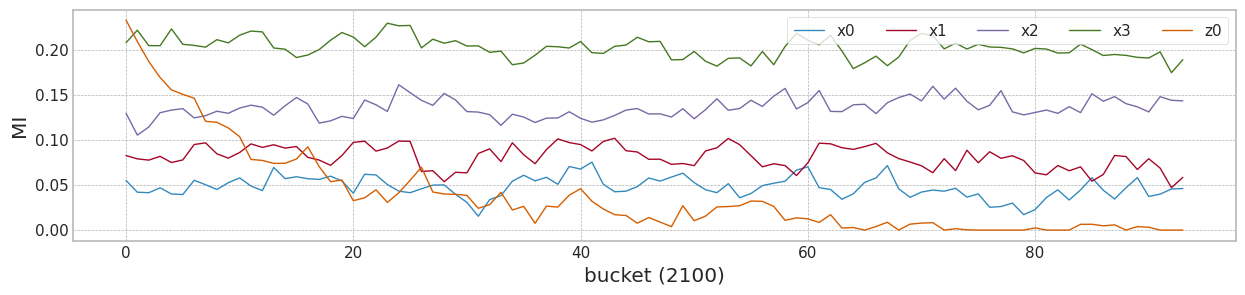

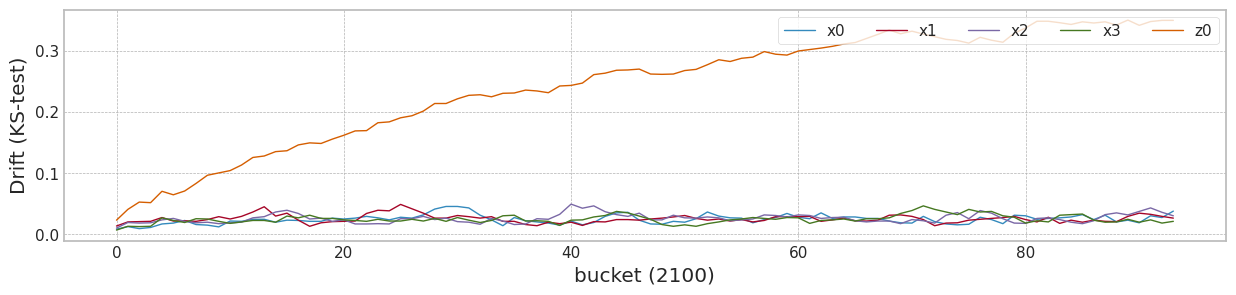

MI Analysis MI Max 0.23289, Min 0.05507, Mean 0.14161, Std 0.06902
cuda:0


100%|██████████| 1000/1000 [00:28<00:00, 35.15it/s]


MSE: 0.23
RMSE: 0.48


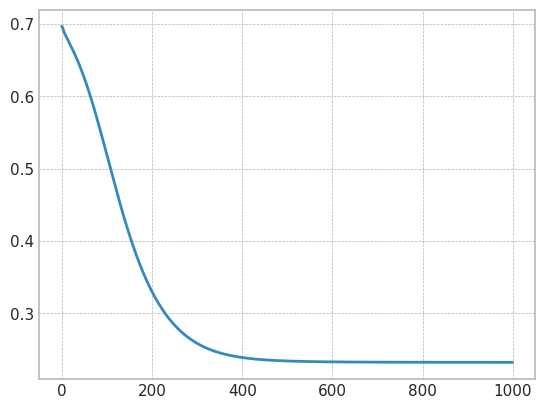

F1 Score:0.89902
Dataset structure X_train, torch.Size([2100, 5]) X_test, torch.Size([2100, 5]) X_live (39600, 5)
Truncate 6000 rows from live_set (39600, 5)


100%|██████████| 94/94 [00:00<00:00, 417.63it/s]


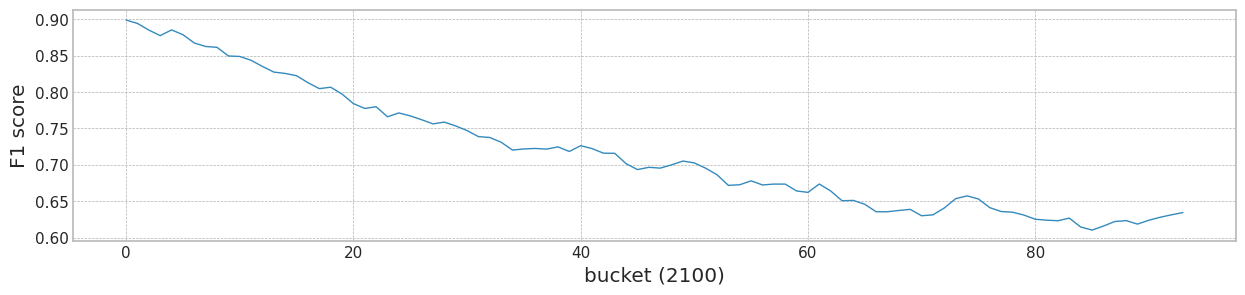

    test_f1   init_f1   mean_f1   last_f1   SUM(MI)
0  0.634438  0.899023  0.717428  0.634438  0.708063


In [62]:
columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
Y = y

train_size = 2100
test_size = 400

X1,Y1 = check_mi_drift(X, Y,train_size, test_size)
model,df = train_classificaion_model(X1,Y1,train_size, test_size)

In [63]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
mine = Net(X1.shape[1]).to(device)
optimizer = torch.optim.Adam(mine.parameters(), lr=0.01)
loss_mse = customLoss(mine)
plot_loss = []

x = torch.tensor(X1.values,dtype=torch.float32).to(device)
y = torch.tensor(Y1,dtype=torch.float32).to(device)

for epoch in tqdm(range(300)):
    mine.zero_grad()
    mine_loss = loss_mse(x,y)
    mine_loss.mean().backward()
    optimizer.step()
    plot_loss.append(-mine_loss.cpu().data.numpy())


plot_loss = np.asarray(plot_loss)
df_loss = pd.DataFrame(plot_loss,columns=X1.columns)

cuda:0


100%|██████████| 300/300 [00:02<00:00, 132.11it/s]


<Axes: >

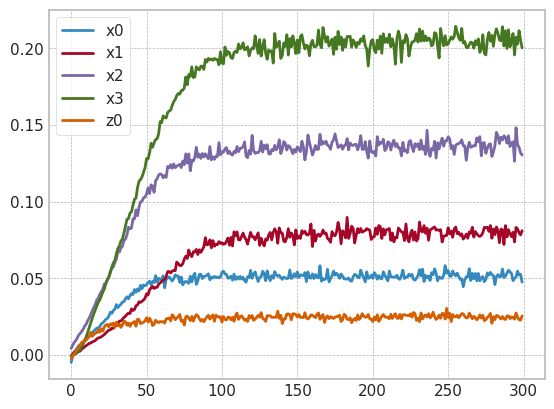

In [64]:
df_loss.plot()

In [65]:
bucket_size = 700
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

x0        x1        x2        x3        z0   b
0      0.511187  0.348595  0.564807  0.468362  0.361192   0
1      0.435937  0.524656  0.595436  0.740184  0.554264   0
2      0.479071  0.682932  0.738867  0.578666  0.629036   0
3      0.572894  0.251745  0.392850  0.506966  0.314811   0
4      0.562890  0.613393  0.481594  0.579096  0.613192   0
...         ...       ...       ...       ...       ...  ..
39995  0.332800  0.214564  0.468946  0.596317 -0.063706  57
39996  0.414601  0.252607  0.438192  0.583473  0.900063  57
39997  0.361400  0.558191  0.590386  0.594890  0.483091  57
39998  0.459619  0.212723  0.148134  0.644631  1.868202  57
39999  0.647526  0.377718  0.782096  0.611511  1.502173  57

[40000 rows x 6 columns]

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:05<00:00, 700.29it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.903435468895079
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 22.08it/s]


mean of drift:
x0    0.024686
x1    0.025496
x2    0.026332
x3    0.024894
z0    0.242933
dtype: float64
Mean F1 for all data: 0.714838986283711
######################### Lambda 0.0 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 241.29it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9012115563839702
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 21.61it/s]


mean of drift:
x0    1.000000
x1    0.998673
x2    1.000000
x3    1.000000
z0    0.979818
dtype: float64
Mean F1 for all data: 0.7361145071072076
######################### Lambda 0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 242.99it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9032558139534883
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 21.94it/s]


mean of drift:
x0    0.941251
x1    0.666596
x2    0.776550
x3    0.504407
z0    0.430937
dtype: float64
Mean F1 for all data: 0.23345557486816892
######################### Lambda 0.2 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 240.81it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.8997214484679666
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 22.26it/s]


mean of drift:
x0    0.795694
x1    0.267538
x2    0.606743
x3    0.366667
z0    0.454645
dtype: float64
Mean F1 for all data: 0.36322602264171333
######################### Lambda 0.3 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 239.72it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.8982259570494864
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 22.04it/s]


mean of drift:
x0    0.831677
x1    0.204205
x2    0.266439
x3    0.221809
z0    0.431165
dtype: float64
Mean F1 for all data: 0.4986505871524538
######################### Lambda 0.4 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 238.45it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9004168596572487
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 22.04it/s]


mean of drift:
x0    0.183617
x1    0.167092
x2    0.086712
x3    0.223642
z0    0.182685
dtype: float64
Mean F1 for all data: 0.8102053501989428
######################### Lambda 0.5 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 237.90it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9037656903765691
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 22.36it/s]


mean of drift:
x0    0.146793
x1    0.075502
x2    0.071535
x3    0.179929
z0    0.171261
dtype: float64
Mean F1 for all data: 0.8034763399589637
######################### Lambda 0.6 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 240.23it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9029261495587552
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 21.10it/s]


mean of drift:
x0    0.110182
x1    0.066125
x2    0.062842
x3    0.159681
z0    0.130334
dtype: float64
Mean F1 for all data: 0.8119758576182476
######################### Lambda 0.7 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 238.24it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9035250463821893
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 21.79it/s]


mean of drift:
x0    0.140689
x1    0.057660
x2    0.050436
x3    0.136565
z0    0.136231
dtype: float64
Mean F1 for all data: 0.7913433875111225
######################### Lambda 0.8 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 239.36it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9044526901669759
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 22.02it/s]


mean of drift:
x0    0.089904
x1    0.041033
x2    0.042523
x3    0.109377
z0    0.169504
dtype: float64
Mean F1 for all data: 0.763938535887006
######################### Lambda 0.9 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 242.46it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9041222788327928
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 22.47it/s]


mean of drift:
x0    0.055664
x1    0.032290
x2    0.035324
x3    0.050066
z0    0.218267
dtype: float64
Mean F1 for all data: 0.7348435423329509


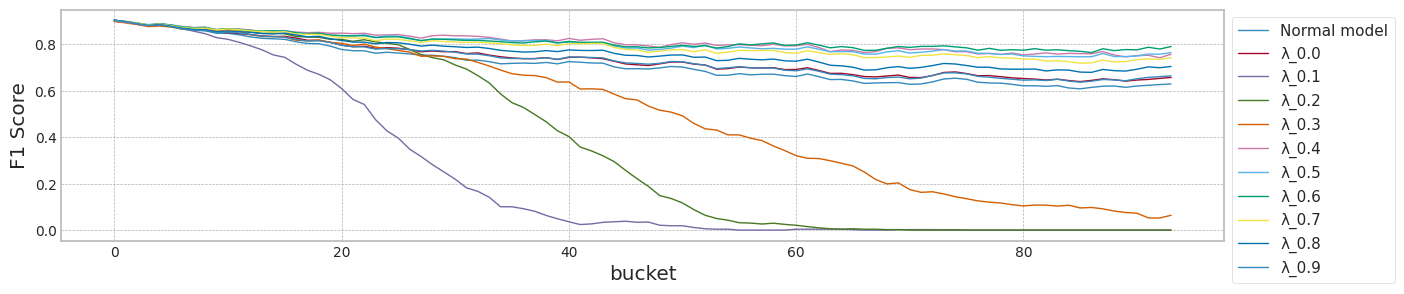

max_mean_lambda= 0.6


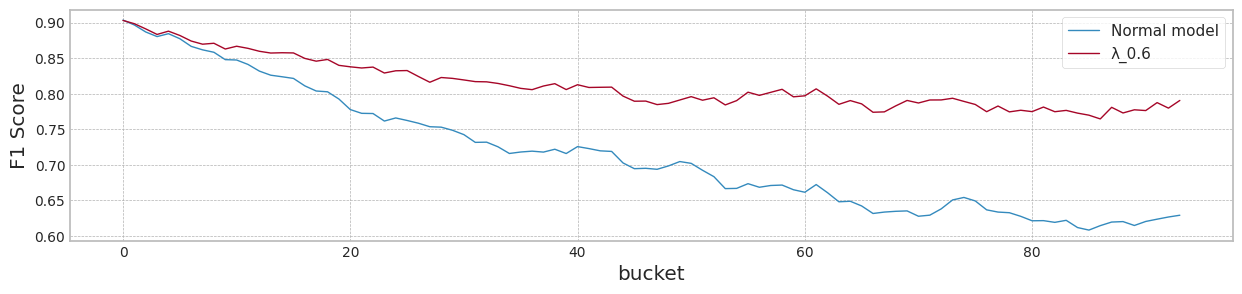

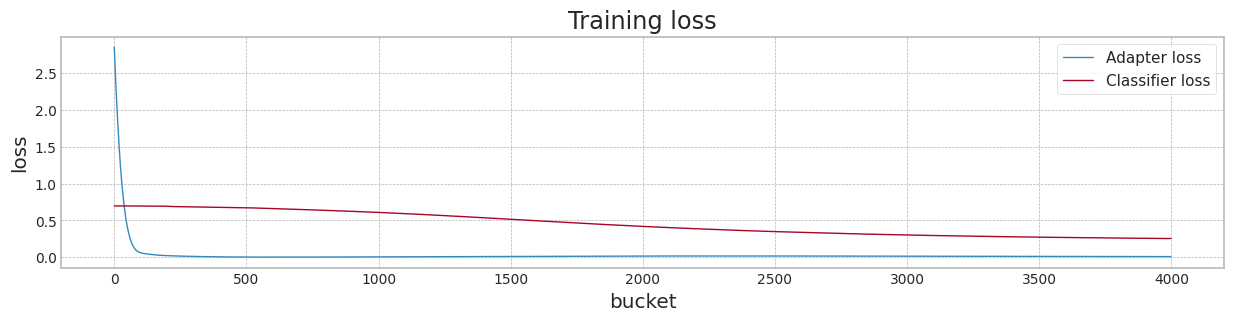

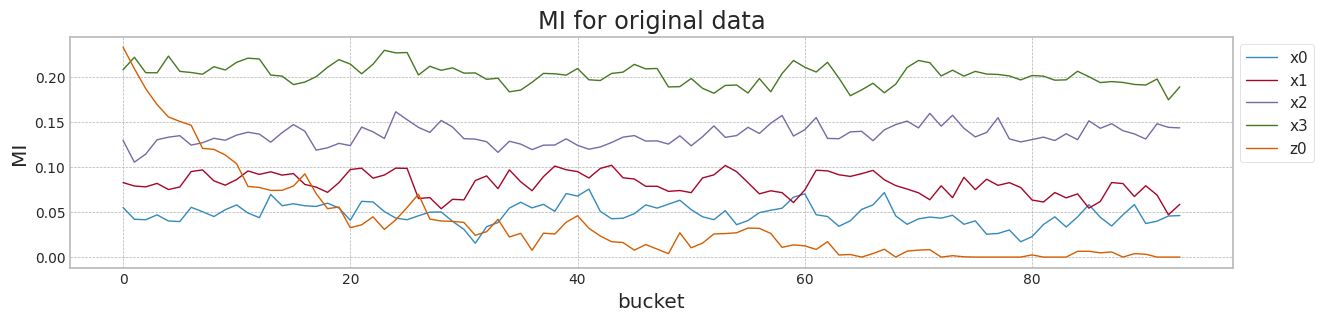

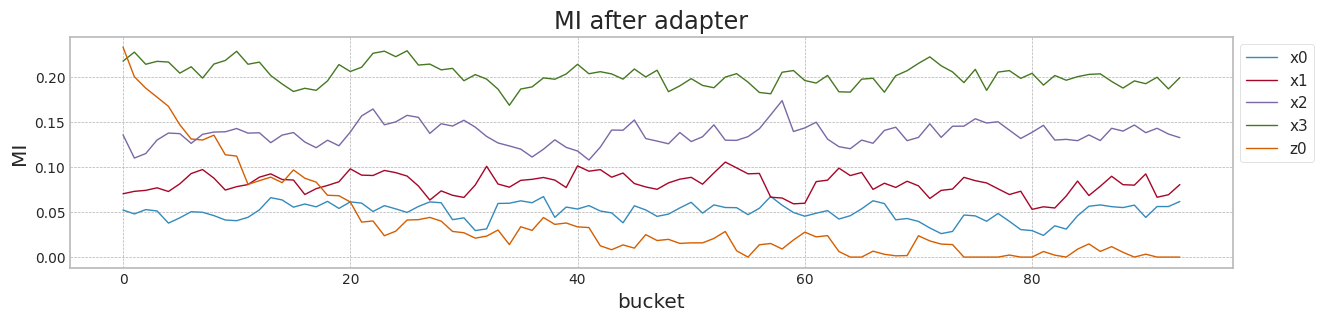

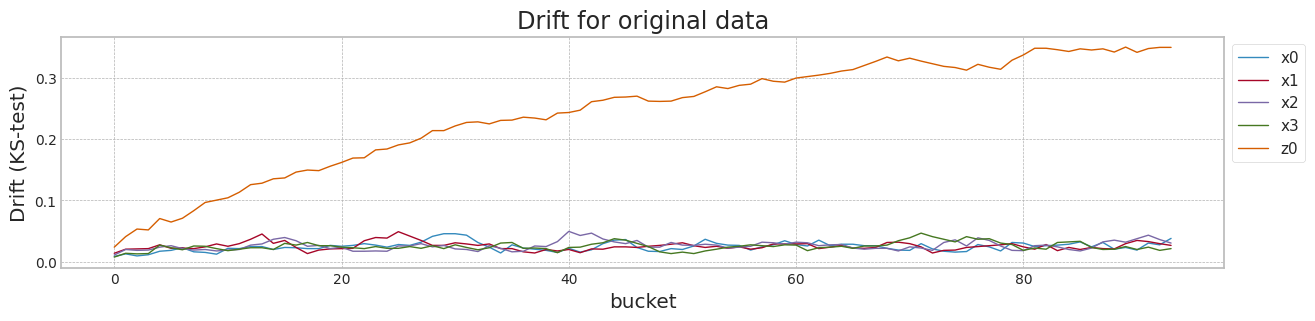

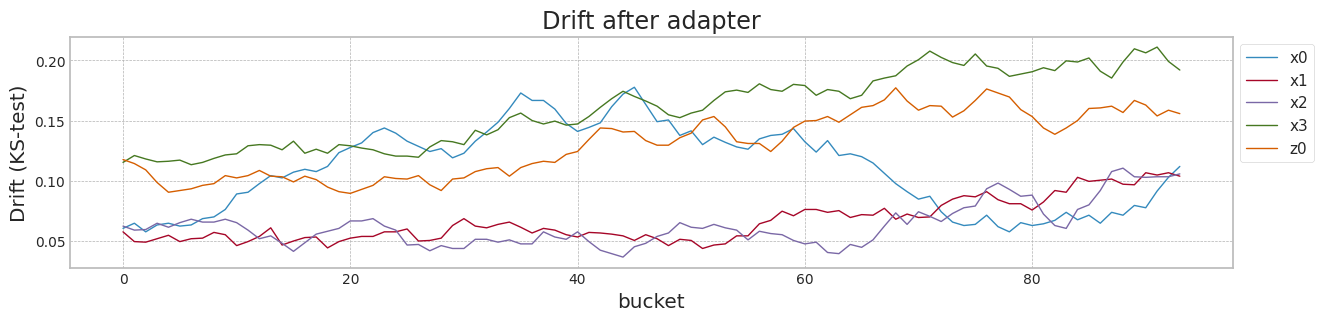

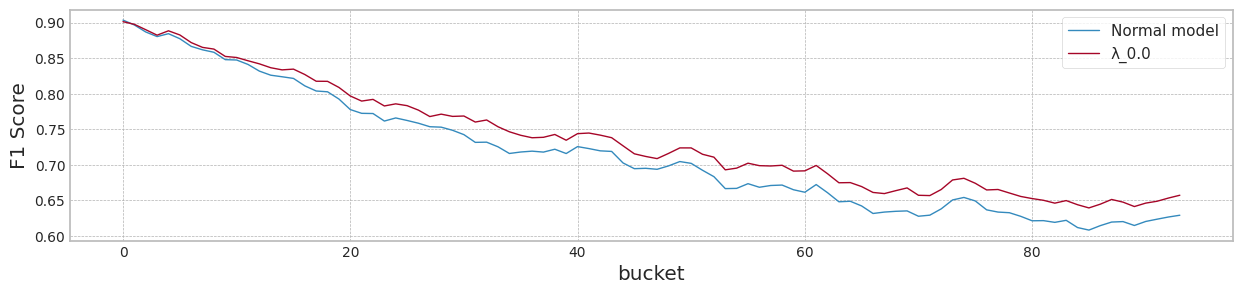

lambda   test_f1   init_f1   mean_f1   last_f1    sum mi  \
0   Case #1, Normal model  0.903435  0.903435  0.714839  0.629255  0.805865   
1                     0.0  0.901212  0.901212  0.736115  0.657349  0.804899   
2                     0.1  0.903256  0.903256  0.233456  0.000000  0.832135   
3                     0.2  0.899721  0.899721  0.363226  0.000000  0.803910   
4                     0.3  0.898226  0.898226  0.498651  0.063717  0.816264   
5                     0.4  0.900417  0.900417  0.810205  0.757282  0.829137   
6                     0.5  0.903766  0.903766  0.803476  0.764277  0.826692   
7                     0.6  0.902926  0.902926  0.811976  0.790525  0.834486   
8                     0.7  0.903525  0.903525  0.791343  0.742487  0.828373   
9                     0.8  0.904453  0.904453  0.763939  0.704620  0.818534   
10                    0.9  0.904122  0.904122  0.734844  0.664190  0.806755   

      std mi  sum * std   sum 1/2   std 1/2   sum 2/2   std 2/2   sum 1-2  \
0   0.088477   0.071300  0.832580  0.099973  0.813471  0.078067  0.019108   
1   0.085955   0.069185  0.852957  0.092599  0.798212  0.078503  0.054744   
2   0.088930   0.074001  0.847317  0.102961  0.834283  0.075907  0.013034   
3   0.091466   0.073531  0.860597  0.108482  0.807001  0.081219  0.053596   
4   0.094567   0.077192  0.850280  0.112014  0.765824  0.083930  0.084456   
5   0.096698   0.080176  0.848264  0.114584  0.811348  0.087061  0.036916   
6   0.097671   0.080744  0.835055  0.107655  0.833215  0.085034  0.001839   
7   0.098288   0.082020  0.850359  0.107400  0.844272  0.090356  0.006087   
8   0.095179   0.078844  0.857861  0.106715  0.844078  0.086722  0.013784   
9   0.094028   0.076965  0.852972  0.104931  0.840089  0.082904  0.012883   
10  0.088055   0.071039  0.836506  0.105443  0.806410  0.074190  0.030096   

     std 1-2   sum 1+2   std 1+2  
0   0.021906  1.646051  0.178040  
1   0.014095  1.651169  0.171102  
2   0.027054  1.681599  0.178868  
3   0.027263  1.667598  0.189701  
4   0.028084  1.616104  0.195944  
5   0.027523  1.659612  0.201645  
6   0.022621  1.668270  0.192689  
7   0.017044  1.694631  0.197756  
8   0.019992  1.701939  0.193437  
9   0.022027  1.693060  0.187836  
10  0.031253  1.642915  0.179632

In [66]:
drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b']+1))

## synthetic data의 생성 (Case #2 MI의 증감(상대적), Drift의 고정)

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature에 대해 y의 비중이 시간에 따라 감소하도록 생성

### Dataset 준비

In [67]:
data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 2.5])

In [68]:
seed_everything()

x1 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x1[:,ix] = np.random.normal(1,cor_,data_size)

In [69]:
x1.shape

(40000, 5)

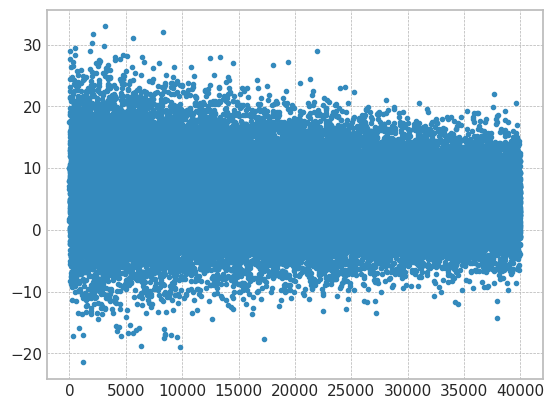

In [70]:
import matplotlib.pyplot as plt

seed_everything()

y1_array = []
cor_const = cor[4]
for ii in range(x1.shape[0]):
    cor[4] = cor[4] - cor_const / x1.shape[0]
    e = np.random.normal(0.0, 2.0)
    y1_array.append(np.sum(cor * x1[ii])+e)

plt.plot(y1_array,'.')

In [71]:
m = 5 #np.mean(y1_array[0:2000])
print(m)
y1 = [1 if y_ > m else 0 for y_ in y1_array]
print(sum(y1))

5
21325


### 실험

MI Analysis MI Max 0.22746, Min 0.00677, Mean 0.06988, Std 0.08433
Dataset structure X_train, (2100, 5) X_test, (2100, 5) X_live (39600, 5)
Truncate 6000 rows from live_set (39600, 5)
Search MI & Drift...for X_live_set (94, 2100, 5)


100%|██████████| 94/94 [00:03<00:00, 23.64it/s]


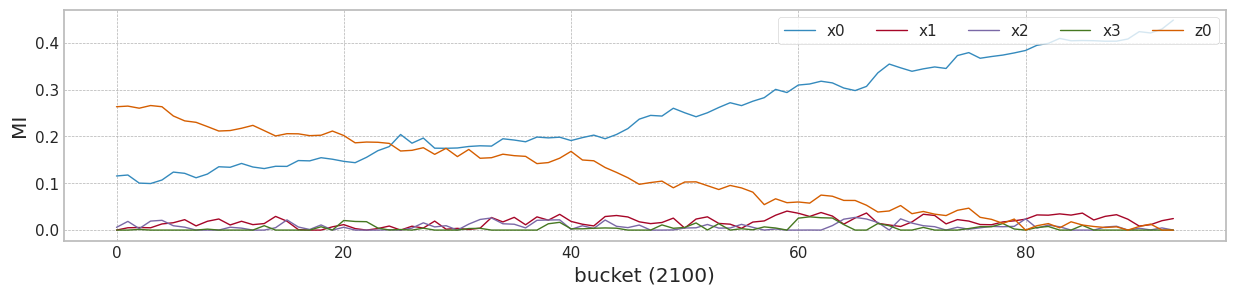

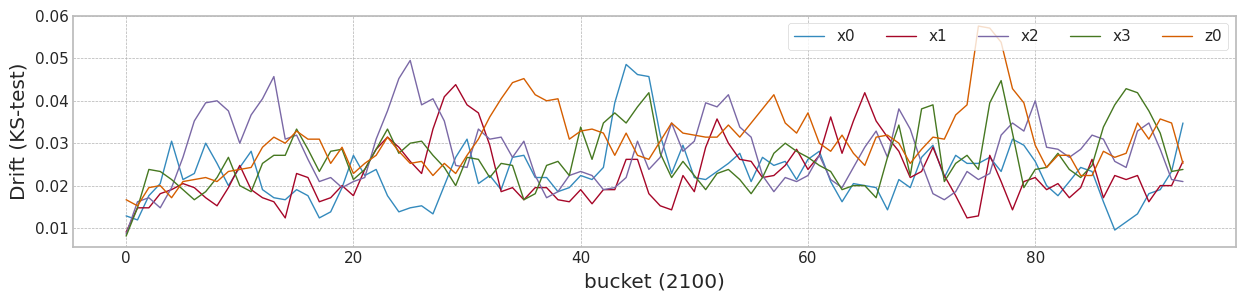

MI Analysis MI Max 0.26359, Min 0.00000, Mean 0.07701, Std 0.10318
cuda:0


100%|██████████| 1000/1000 [00:28<00:00, 35.16it/s]


MSE: 0.05
RMSE: 0.22


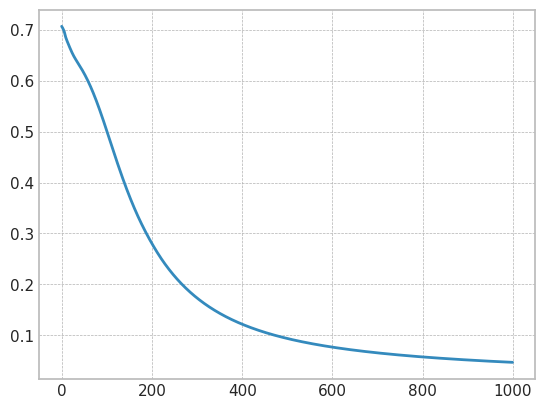

F1 Score:0.99672
Dataset structure X_train, torch.Size([2100, 5]) X_test, torch.Size([2100, 5]) X_live (39600, 5)
Truncate 6000 rows from live_set (39600, 5)


100%|██████████| 94/94 [00:00<00:00, 422.33it/s]


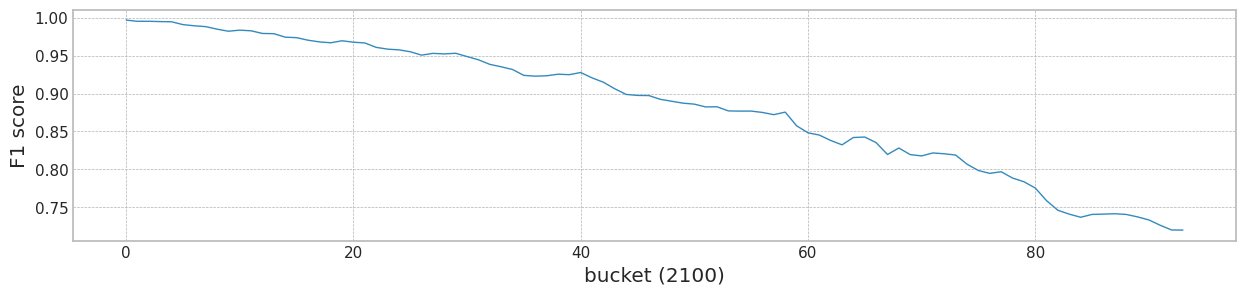

    test_f1   init_f1   mean_f1   last_f1   SUM(MI)
0  0.720106  0.996721  0.884106  0.720106  0.385054


In [72]:
columns=['x0','x1','x2','x3','z0']
X1 = pd.DataFrame(x1,columns=columns)

train_size = 2100
test_size = 400

X1,Y1 = check_mi_drift(X1, y1,train_size, test_size)
model,df = train_classificaion_model(X1,Y1,train_size, test_size)

In [73]:
bucket_size = 700
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

x0        x1        x2        x3        z0   b
0      0.519751  0.497734  0.270011  0.522616  0.339159   0
1      0.605565  0.420412  0.467312  0.555299  0.666164   0
2      0.551222  0.464734  0.644682  0.708350  0.471856   0
3      0.335978  0.646524  0.283118  0.500668  0.609888   0
4      0.496805  0.550860  0.566753  0.433822  0.472373   0
...         ...       ...       ...       ...       ...  ..
39995  0.325122  0.399822  0.241452  0.581867  0.717378  57
39996  0.350268  0.483875  0.284085  0.549051  0.701927  57
39997  0.553850  0.343824  0.504892  0.549911  0.491374  57
39998  0.426469  0.530132  0.239389  0.239540  0.775500  57
39999  0.532744  0.637825  0.302647  0.754479  0.511368  57

[40000 rows x 6 columns]

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:05<00:00, 712.58it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9672462596037202
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 22.08it/s]


mean of drift:
x0    0.022842
x1    0.022796
x2    0.028055
x3    0.026353
z0    0.030664
dtype: float64
Mean F1 for all data: 0.8602220901939729
######################### Lambda 0.0 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 239.83it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9983593109105825
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 21.94it/s]


mean of drift:
x0    0.998815
x1    0.711793
x2    1.000000
x3    1.000000
z0    0.820861
dtype: float64
Mean F1 for all data: 0.8854132688770661
######################### Lambda 0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 237.90it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9848173984407058
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 21.76it/s]


mean of drift:
x0    0.576302
x1    0.600968
x2    0.537791
x3    0.544635
z0    0.598511
dtype: float64
Mean F1 for all data: 0.8410668172908001
######################### Lambda 0.2 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 237.05it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9763843648208469
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 22.02it/s]


mean of drift:
x0    0.451692
x1    0.333191
x2    0.147573
x3    0.062573
z0    0.574240
dtype: float64
Mean F1 for all data: 0.8488404800836111
######################### Lambda 0.3 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 237.04it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.967479674796748
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 21.65it/s]


mean of drift:
x0    0.378029
x1    0.165740
x2    0.064276
x3    0.100669
z0    0.550740
dtype: float64
Mean F1 for all data: 0.8173703757001441
######################### Lambda 0.4 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 240.66it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9655451965950548
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 21.78it/s]


mean of drift:
x0    0.300218
x1    0.168430
x2    0.048749
x3    0.078799
z0    0.533212
dtype: float64
Mean F1 for all data: 0.8051159868569592
######################### Lambda 0.5 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 241.39it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.962363415621206
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 21.96it/s]


mean of drift:
x0    0.237077
x1    0.125041
x2    0.040588
x3    0.051753
z0    0.482857
dtype: float64
Mean F1 for all data: 0.8148996311411151
######################### Lambda 0.6 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 239.38it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9587712206952305
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 21.91it/s]


mean of drift:
x0    0.268146
x1    0.103556
x2    0.030284
x3    0.041854
z0    0.414904
dtype: float64
Mean F1 for all data: 0.8656958644528677
######################### Lambda 0.7 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 239.83it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9568722289399437
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 21.73it/s]


mean of drift:
x0    0.190193
x1    0.048541
x2    0.034504
x3    0.035233
z0    0.298156
dtype: float64
Mean F1 for all data: 0.833517894872967
######################### Lambda 0.8 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 240.04it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9557522123893806
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 22.40it/s]


mean of drift:
x0    0.156236
x1    0.037077
x2    0.038820
x3    0.033232
z0    0.163475
dtype: float64
Mean F1 for all data: 0.9059692389130941
######################### Lambda 0.9 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 239.05it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9539447336804164
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 22.32it/s]


mean of drift:
x0    0.104782
x1    0.030390
x2    0.043136
x3    0.033946
z0    0.162421
dtype: float64
Mean F1 for all data: 0.8337186700481274


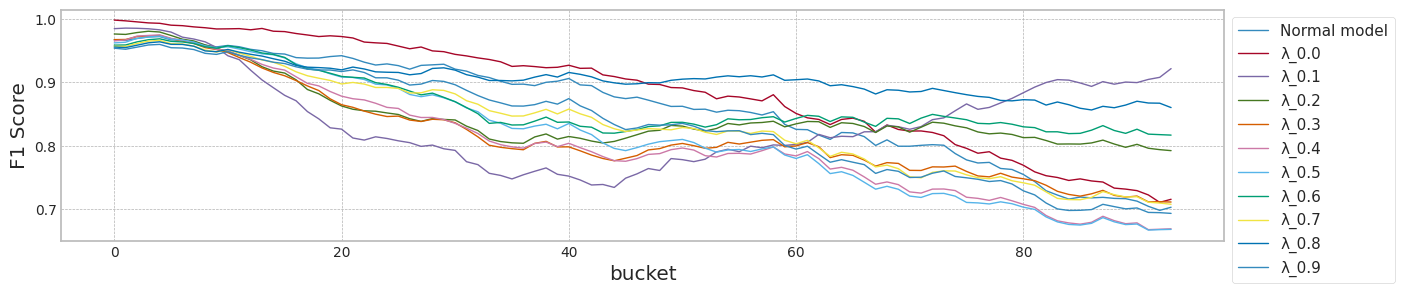

max_mean_lambda= 0.8


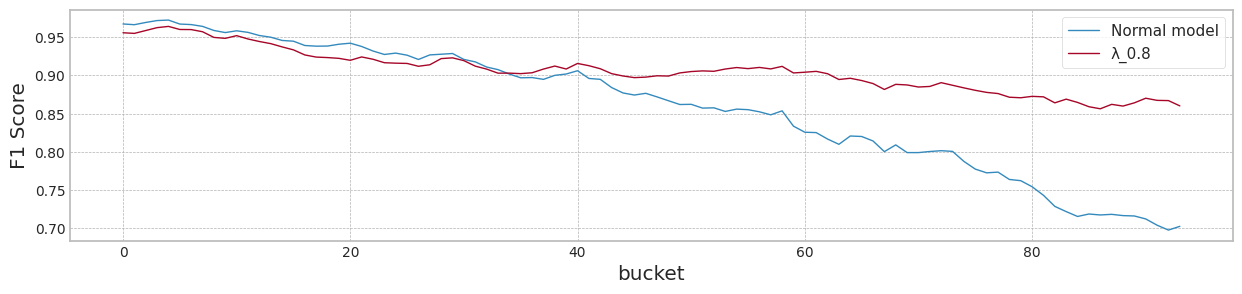

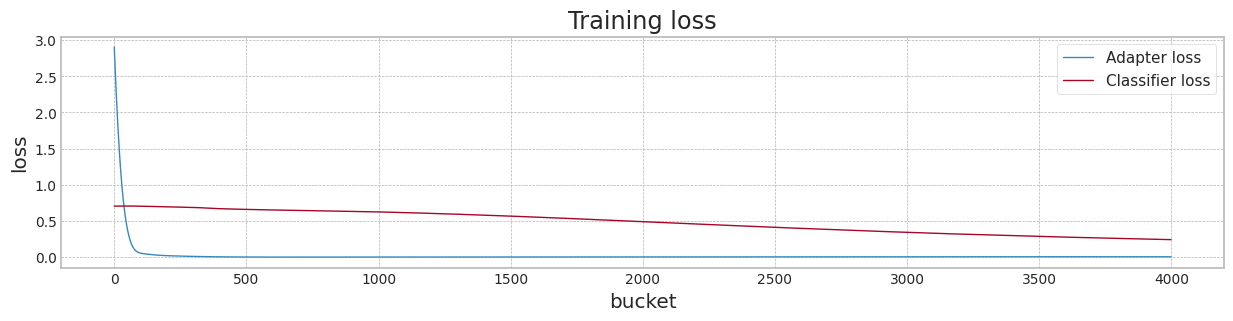

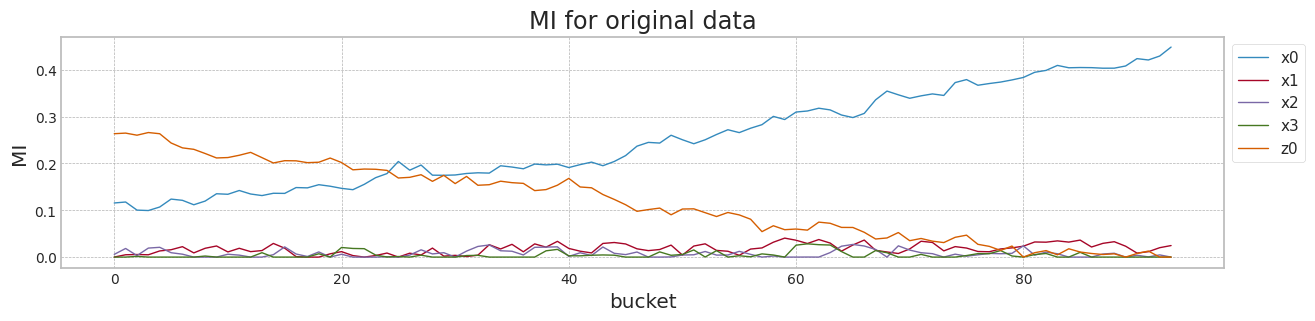

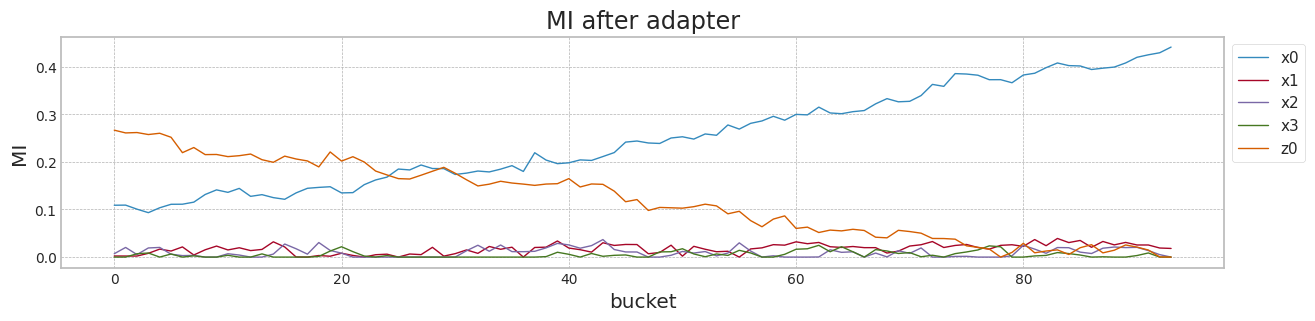

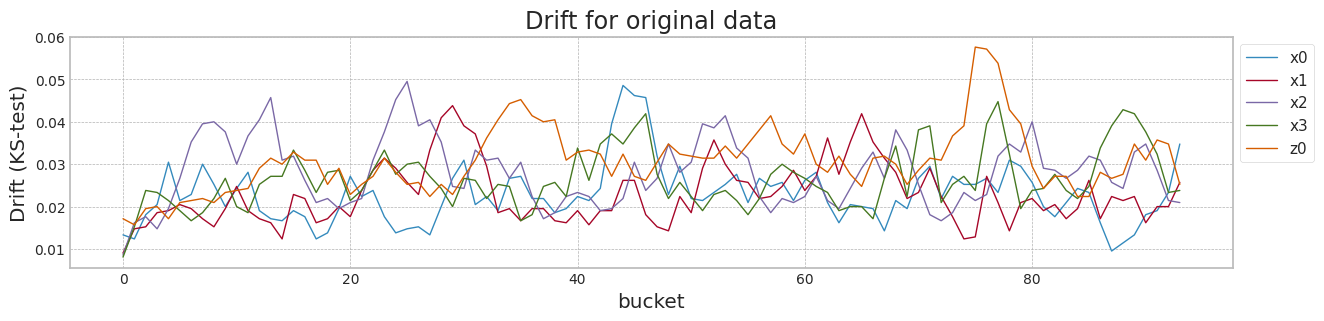

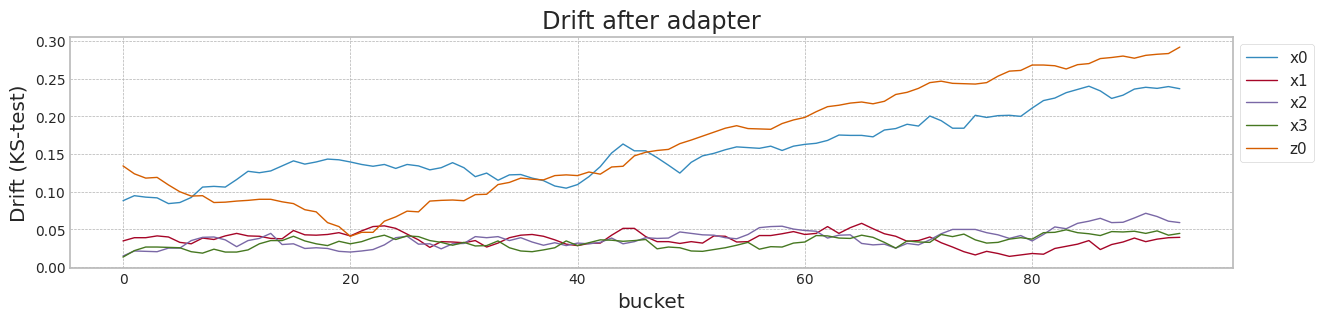

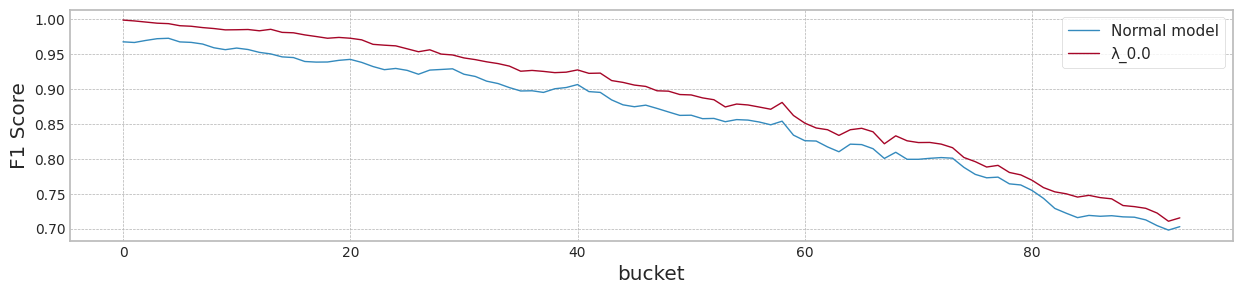

lambda   test_f1   init_f1   mean_f1   last_f1    sum mi  \
0   Case #1, Normal model  0.967246  0.967246  0.860222  0.702726  0.415980   
1                     0.0  0.998359  0.998359  0.885413  0.715321  0.369249   
2                     0.1  0.984817  0.984817  0.841067  0.921712  0.408733   
3                     0.2  0.976384  0.976384  0.848840  0.792151  0.414221   
4                     0.3  0.967480  0.967480  0.817370  0.710999  0.392116   
5                     0.4  0.965545  0.965545  0.805116  0.668695  0.398526   
6                     0.5  0.962363  0.962363  0.814900  0.667792  0.403900   
7                     0.6  0.958771  0.958771  0.865696  0.816680  0.434824   
8                     0.7  0.956872  0.956872  0.833518  0.707439  0.418543   
9                     0.8  0.955752  0.955752  0.905969  0.860168  0.413663   
10                    0.9  0.953945  0.953945  0.833719  0.693041  0.409915   

      std mi  sum * std   sum 1/2   std 1/2   sum 2/2   std 2/2   sum 1-2  \
0   0.123106   0.051210  0.429311  0.108170  0.413738  0.127884  0.015573   
1   0.099327   0.036676  0.395206  0.098083  0.390733  0.099262  0.004473   
2   0.106835   0.043667  0.411947  0.101154  0.393733  0.107808  0.018214   
3   0.113777   0.047129  0.433499  0.108322  0.395876  0.111696  0.037623   
4   0.116791   0.045796  0.413505  0.113049  0.409213  0.116915  0.004292   
5   0.118346   0.047164  0.428597  0.113215  0.398039  0.116950  0.030559   
6   0.120107   0.048511  0.419323  0.111946  0.391210  0.121969  0.028113   
7   0.126013   0.054794  0.439596  0.114176  0.417019  0.131551  0.022577   
8   0.126413   0.052909  0.414729  0.111253  0.411115  0.133921  0.003614   
9   0.126411   0.052291  0.416550  0.110898  0.415451  0.134072  0.001098   
10  0.121277   0.049713  0.403813  0.107451  0.440660  0.135753  0.036847   

     std 1-2   sum 1+2   std 1+2  
0   0.019715  0.843050  0.236054  
1   0.001179  0.785939  0.197346  
2   0.006654  0.805679  0.208963  
3   0.003374  0.829375  0.220017  
4   0.003866  0.822718  0.229964  
5   0.003736  0.826636  0.230165  
6   0.010023  0.810533  0.233914  
7   0.017374  0.856615  0.245727  
8   0.022668  0.825844  0.245173  
9   0.023174  0.832001  0.244970  
10  0.028301  0.844472  0.243204

In [74]:
drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b']+1))

## synthetic data의 생성 (Case #3 MI의 증감(상대적), Drift의 증가)

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift, MI는 고정

### Dataset 준비

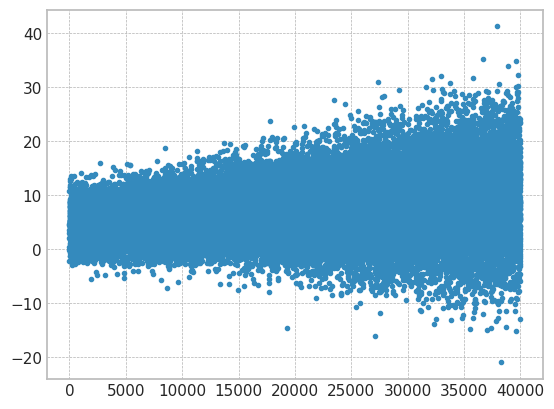

In [75]:
import matplotlib.pyplot as plt

seed_everything(2)

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

x2 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x2[:,ix] = np.random.normal(1,cor_,data_size)

y2_array = []
cor_const = 3/x2.shape[0]
for ii in range(x2.shape[0]):
    e = np.random.normal(0.0+10*ii/40000, 5*cor_const * ii)
    e1 = 0.0 #np.random.normal(0.0, cor_const * ii)
    x2[ii,4] = x2[ii,4] + e
    y2_array.append(np.sum(cor * x2[ii])+e1)

plt.plot(y2_array,'.')

In [76]:
m = 5 #np.mean(y2_array)
print(m)
y2 = [1 if y_ > m else 0 for y_ in y2_array]
sum(y2)

5


26135

### 실험

MI Analysis MI Max 0.22487, Min 0.00191, Mean 0.07138, Std 0.08241
Dataset structure X_train, (2100, 5) X_test, (2100, 5) X_live (39600, 5)
Truncate 6000 rows from live_set (39600, 5)
Search MI & Drift...for X_live_set (94, 2100, 5)


100%|██████████| 94/94 [00:04<00:00, 23.35it/s]


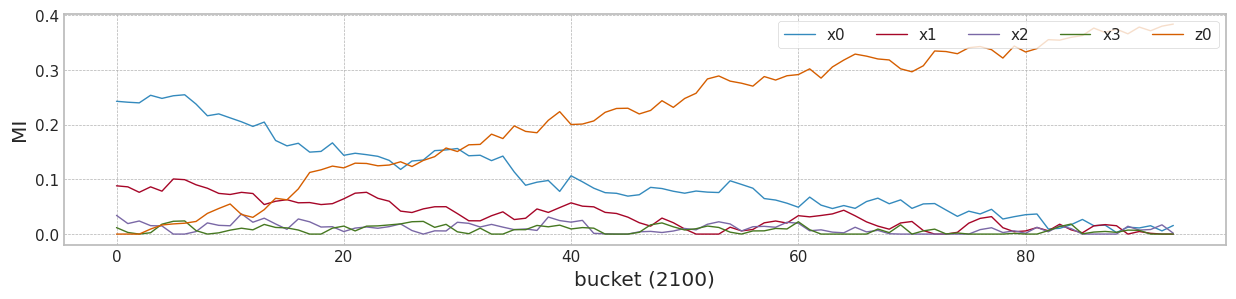

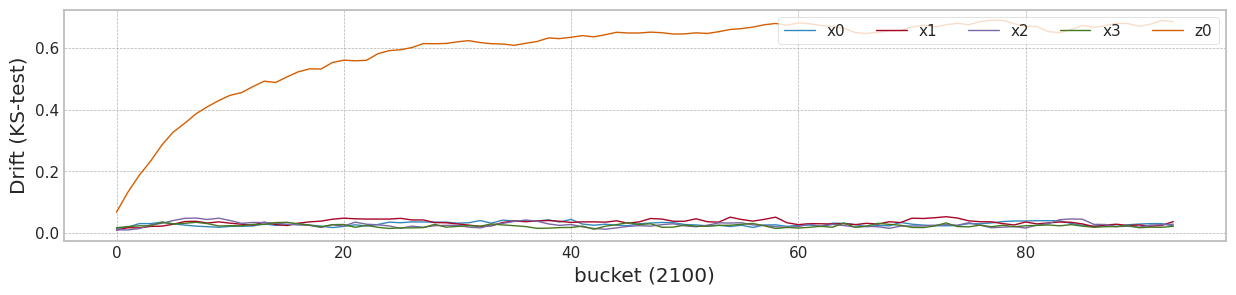

In [77]:
columns=['x0','x1','x2','x3','z0']
X2 = pd.DataFrame(x2,columns=columns)

train_size = 2100
test_size = 400

X1,Y1 = check_mi_drift(X2, y2,train_size, test_size)

In [78]:
bucket_size = 700
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

x0        x1        x2        x3        z0   b
0      0.391378  0.179737  0.412932  0.753057  0.323094   0
1      0.439860  0.516005  0.490105  0.539427  0.381987   0
2      0.160132  0.417404  0.389905  0.422728  0.333579   0
3      0.668025  0.621269  0.663604  0.507297  0.518229   0
4      0.206230  0.473113  0.366847  0.582620  0.346354   0
...         ...       ...       ...       ...       ...  ..
39995  0.321563  0.552908  0.399885  0.609071  2.963294  57
39996  0.380574  0.622177  0.454242  0.440279  0.745924  57
39997  0.370265  0.491261  0.156487  0.513411  5.144436  57
39998  0.388943  0.572886  0.872513  0.681624 -0.915288  57
39999  0.406888  0.446354  0.462540  0.508977  0.220015  57

[40000 rows x 6 columns]

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:05<00:00, 689.57it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9546332046332047
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 21.92it/s]


mean of drift:
x0    0.028779
x1    0.034777
x2    0.026469
x3    0.023323
z0    0.593354
dtype: float64
Mean F1 for all data: 0.8606591126001283
######################### Lambda 0.0 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 233.20it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9975926817525276
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 21.66it/s]


mean of drift:
x0    0.698622
x1    0.745927
x2    0.999894
x3    1.000000
z0    0.751241
dtype: float64
Mean F1 for all data: 0.9081319020087356
######################### Lambda 0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 240.25it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9899086977414705
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 22.05it/s]


mean of drift:
x0    0.462675
x1    0.477340
x2    0.536586
x3    0.539225
z0    0.585279
dtype: float64
Mean F1 for all data: 0.4834406096450932
######################### Lambda 0.2 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 240.02it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9860240963855421
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 20.83it/s]


mean of drift:
x0    0.760831
x1    0.195030
x2    0.435299
x3    0.554362
z0    0.824585
dtype: float64
Mean F1 for all data: 0.260105108834818
######################### Lambda 0.3 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 233.90it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9801260300533203
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 22.26it/s]


mean of drift:
x0    0.740046
x1    0.207406
x2    0.245887
x3    0.460410
z0    0.928419
dtype: float64
Mean F1 for all data: 0.23178966545010438
######################### Lambda 0.4 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 237.90it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9723435225618633
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 22.00it/s]


mean of drift:
x0    0.812229
x1    0.170572
x2    0.144939
x3    0.413632
z0    0.929443
dtype: float64
Mean F1 for all data: 0.17561824299200646
######################### Lambda 0.5 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 240.28it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9598840019333011
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 22.19it/s]


mean of drift:
x0    0.778693
x1    0.170729
x2    0.075978
x3    0.365299
z0    0.882112
dtype: float64
Mean F1 for all data: 0.17933983468891582
######################### Lambda 0.6 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 243.60it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9478260869565218
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 22.12it/s]


mean of drift:
x0    0.735253
x1    0.087700
x2    0.147168
x3    0.307685
z0    0.776864
dtype: float64
Mean F1 for all data: 0.1962794458596071
######################### Lambda 0.7 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 241.43it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.939205361416946
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 21.54it/s]


mean of drift:
x0    0.671986
x1    0.253804
x2    0.155238
x3    0.128349
z0    0.613956
dtype: float64
Mean F1 for all data: 0.2605550238048012
######################### Lambda 0.8 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 237.88it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9458552946813608
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 21.38it/s]


mean of drift:
x0    0.153197
x1    0.158176
x2    0.130091
x3    0.079873
z0    0.596125
dtype: float64
Mean F1 for all data: 0.6861289640442298
######################### Lambda 0.9 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 224.04it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9486317810849736
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 21.23it/s]


mean of drift:
x0    0.103744
x1    0.201560
x2    0.105821
x3    0.048323
z0    0.592862
dtype: float64
Mean F1 for all data: 0.8207602746658569


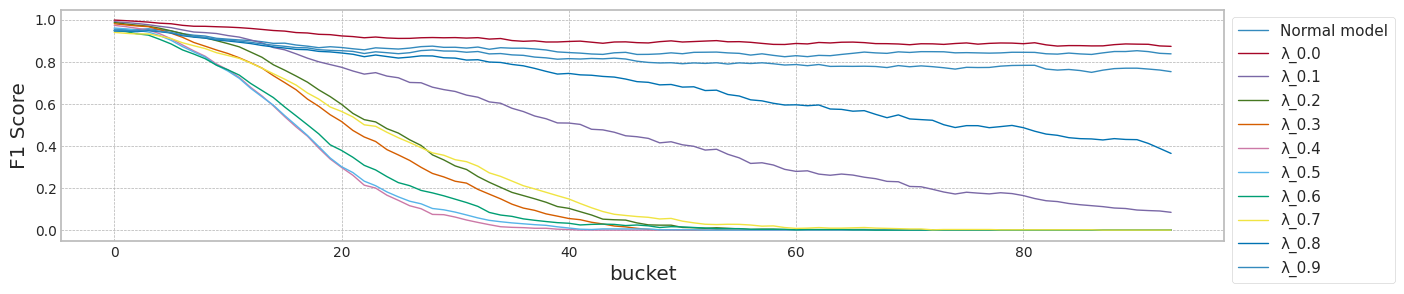

max_mean_lambda= 0.0


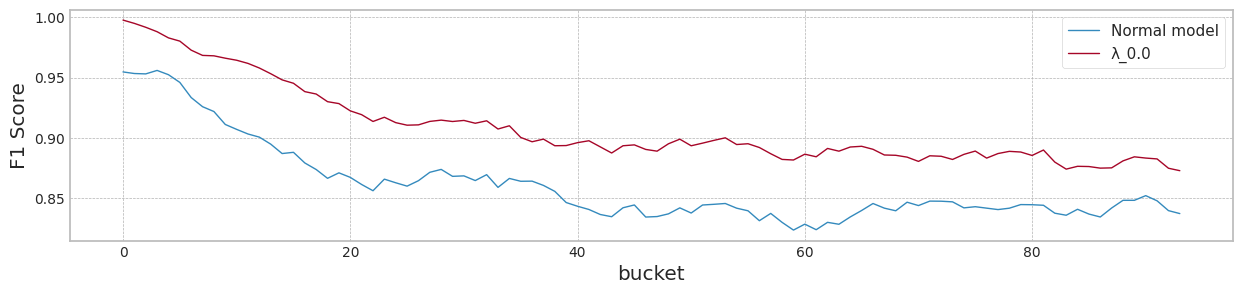

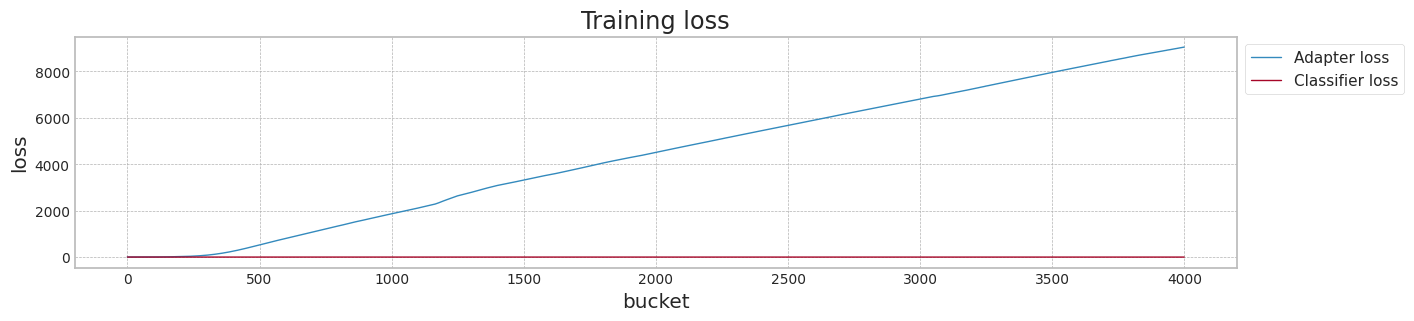

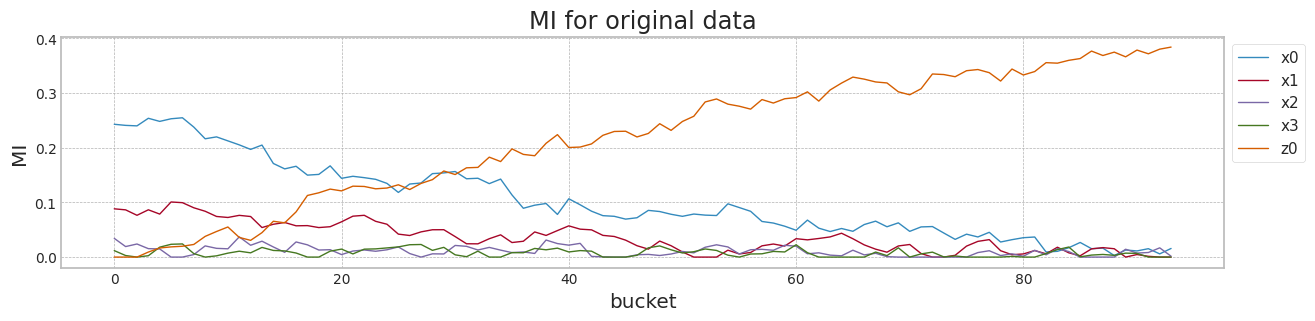

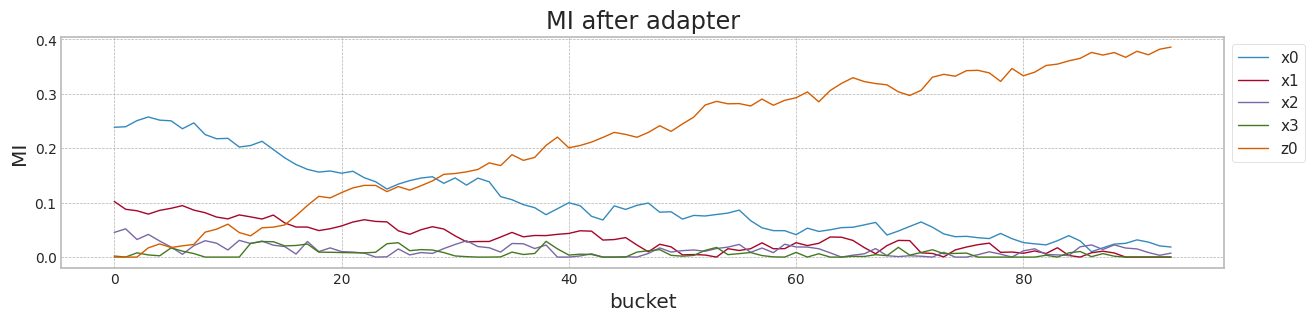

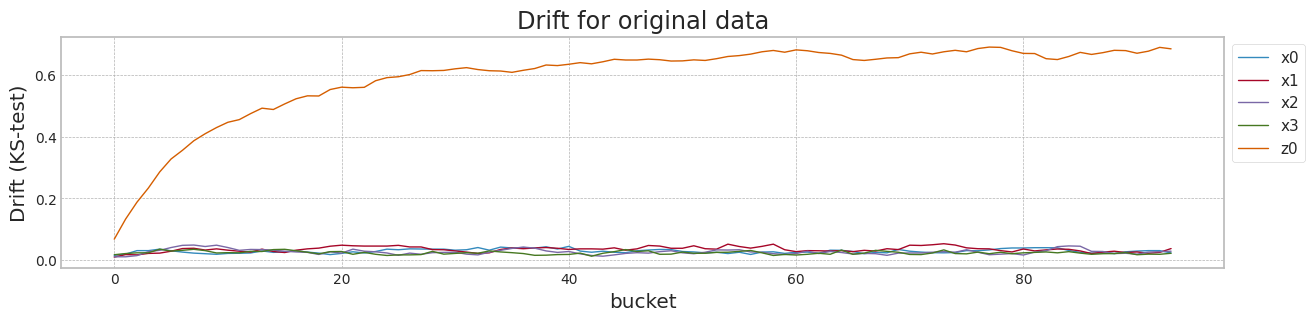

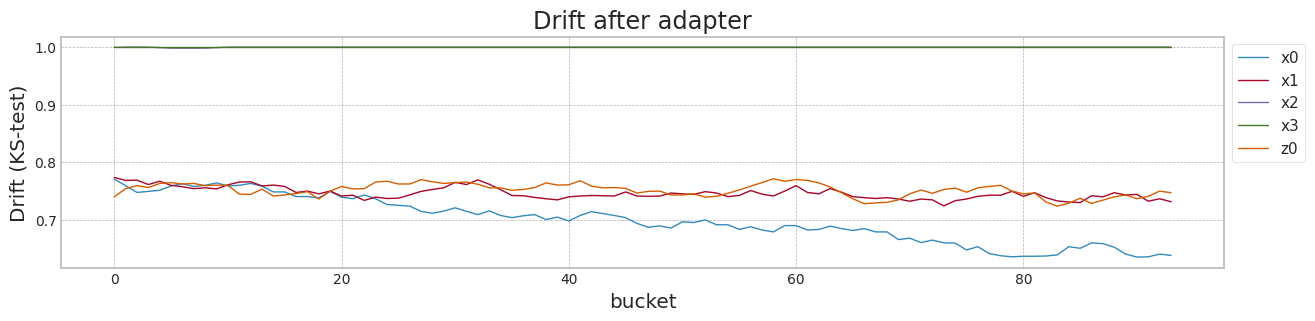

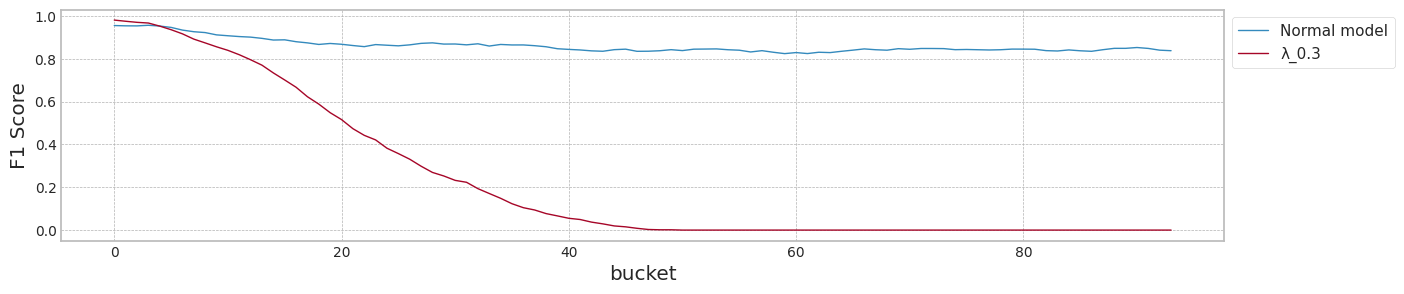

lambda   test_f1   init_f1   mean_f1   last_f1    sum mi  \
0   Case #1, Normal model  0.954633  0.954633  0.860659  0.837245  0.382992   
1                     0.0  0.997593  0.997593  0.908132  0.872793  0.388997   
2                     0.1  0.989909  0.989909  0.483441  0.084345  0.402980   
3                     0.2  0.986024  0.986024  0.260105  0.000000  0.395585   
4                     0.3  0.980126  0.980126  0.231790  0.000000  0.368554   
5                     0.4  0.972344  0.972344  0.175618  0.000000  0.377944   
6                     0.5  0.959884  0.959884  0.179340  0.000000  0.380190   
7                     0.6  0.947826  0.947826  0.196279  0.000000  0.386084   
8                     0.7  0.939205  0.939205  0.260555  0.000000  0.389927   
9                     0.8  0.945855  0.945855  0.686129  0.364108  0.396197   
10                    0.9  0.948632  0.948632  0.820760  0.752516  0.403725   

      std mi  sum * std   sum 1/2   std 1/2   sum 2/2   std 2/2   sum 1-2  \
0   0.092989   0.035614  0.376433  0.096380  0.391474  0.098140  0.015041   
1   0.089852   0.034952  0.375198  0.081673  0.405122  0.094460  0.029924   
2   0.089882   0.036221  0.381891  0.084850  0.393070  0.097461  0.011179   
3   0.096978   0.038363  0.394872  0.091727  0.382677  0.099977  0.012195   
4   0.093515   0.034465  0.404016  0.088066  0.408281  0.093376  0.004265   
5   0.093914   0.035494  0.408208  0.091055  0.386650  0.099149  0.021559   
6   0.101694   0.038663  0.399888  0.099221  0.391449  0.102239  0.008438   
7   0.097416   0.037611  0.411006  0.099272  0.388165  0.094053  0.022841   
8   0.108867   0.042450  0.390918  0.102343  0.393993  0.109116  0.003074   
9   0.104582   0.041435  0.402188  0.105743  0.399218  0.103042  0.002970   
10  0.104097   0.042027  0.381012  0.102268  0.400217  0.098639  0.019204   

     std 1-2   sum 1+2   std 1+2  
0   0.001760  0.767908  0.194520  
1   0.012787  0.780321  0.176133  
2   0.012611  0.774962  0.182312  
3   0.008250  0.777549  0.191704  
4   0.005310  0.812297  0.181441  
5   0.008094  0.794858  0.190205  
6   0.003018  0.791337  0.201460  
7   0.005218  0.799171  0.193325  
8   0.006773  0.784911  0.211459  
9   0.002701  0.801406  0.208786  
10  0.003629  0.781229  0.200907

In [79]:
drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b']+1))

## synthetic data의 생성 (Case #4 MI의 고정, Drift의 증가)

### Dataset 준비

In [80]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

y3= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x3 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    '''
    x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)
    '''
    # z0
    if ix == 4:
        for ii in range(len(y3)):
            x3[ii,ix] = y3[ii] + np.random.normal(0.0 + 4*ii/data_size,cor_)
    else:
        x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)


### 실험

MI Analysis MI Max 0.20278, Min 0.05089, Mean 0.11172, Std 0.05282
Dataset structure X_train, (2100, 5) X_test, (2100, 5) X_live (39600, 5)
Truncate 6000 rows from live_set (39600, 5)
Search MI & Drift...for X_live_set (94, 2100, 5)


100%|██████████| 94/94 [00:03<00:00, 23.62it/s]


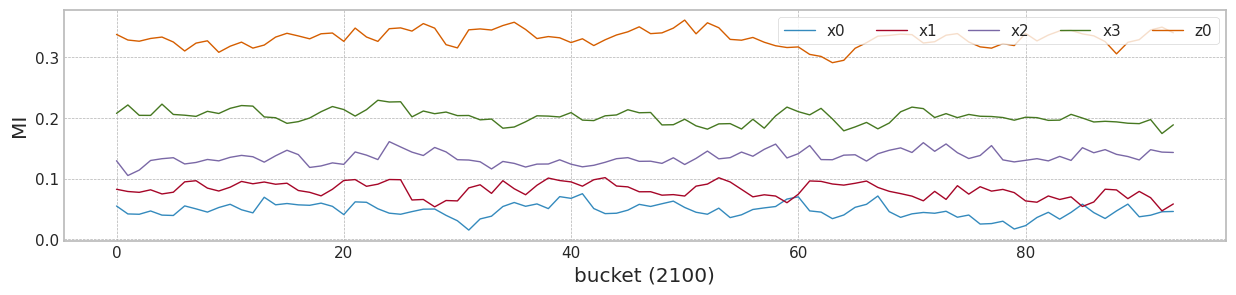

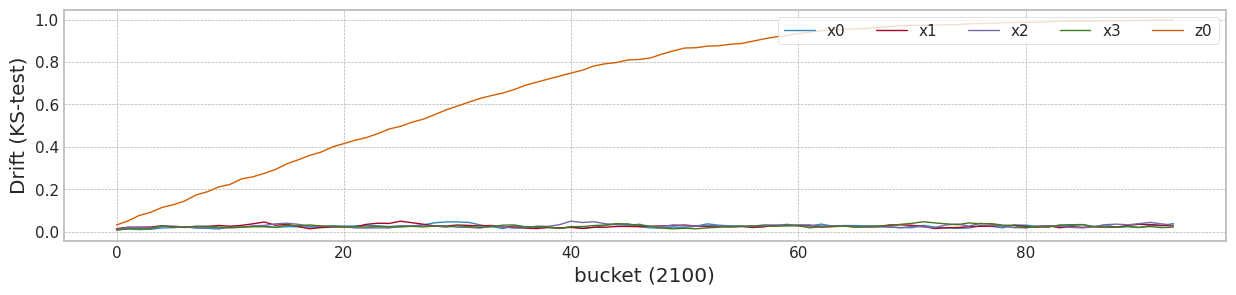

In [81]:
columns=['x0','x1','x2','x3','z0']
X3 = pd.DataFrame(x3,columns=columns)

train_size = 2100
test_size = 400

X1,Y1 = check_mi_drift(X3, y3,train_size, test_size)

In [82]:
bucket_size = 700
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

x0        x1        x2        x3        z0   b
0      0.511187  0.348595  0.564807  0.468362  0.503588   0
1      0.435937  0.524656  0.595436  0.740184  0.617637   0
2      0.479071  0.682932  0.738867  0.578666  0.364513   0
3      0.572894  0.251745  0.392850  0.506966  0.371604   0
4      0.562890  0.613393  0.481594  0.579096  0.638879   0
...         ...       ...       ...       ...       ...  ..
39995  0.332800  0.214564  0.468946  0.596317  1.080212  57
39996  0.414601  0.252607  0.438192  0.583473  1.097577  57
39997  0.361400  0.558191  0.590386  0.594890  1.454822  57
39998  0.459619  0.212723  0.148134  0.644631  1.259975  57
39999  0.647526  0.377718  0.782096  0.611511  1.451896  57

[40000 rows x 6 columns]

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 663.81it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9285389167045972
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 22.37it/s]


mean of drift:
x0    0.024686
x1    0.025496
x2    0.026332
x3    0.024894
z0    0.702335
dtype: float64
Mean F1 for all data: 0.7380407802994192
######################### Lambda 0.0 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 239.60it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9308118081180812
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 21.72it/s]


mean of drift:
x0    1.000000
x1    1.000000
x2    1.000000
x3    1.000000
z0    0.976444
dtype: float64
Mean F1 for all data: 0.8242212290896187
######################### Lambda 0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 237.41it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9242843951985227
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 21.72it/s]


mean of drift:
x0    0.603029
x1    0.382376
x2    0.666165
x3    0.619544
z0    0.468916
dtype: float64
Mean F1 for all data: 0.7490789157540364
######################### Lambda 0.2 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 233.72it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9225806451612903
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 20.88it/s]


mean of drift:
x0    0.892882
x1    0.058014
x2    0.126545
x3    0.555902
z0    0.520917
dtype: float64
Mean F1 for all data: 0.4628713345024209
######################### Lambda 0.3 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 230.89it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9229349330872173
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 19.99it/s]


mean of drift:
x0    0.495821
x1    0.247994
x2    0.321272
x3    0.547634
z0    0.553014
dtype: float64
Mean F1 for all data: 0.754807262384896
######################### Lambda 0.4 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 234.21it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9165514061779623
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 21.49it/s]


mean of drift:
x0    0.675502
x1    0.297852
x2    0.215507
x3    0.462432
z0    0.538901
dtype: float64
Mean F1 for all data: 0.7708908304600993
######################### Lambda 0.5 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 233.68it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9242076251722553
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 20.06it/s]


mean of drift:
x0    0.188009
x1    0.051439
x2    0.062107
x3    0.198399
z0    0.567558
dtype: float64
Mean F1 for all data: 0.7758141122302276
######################### Lambda 0.6 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 232.55it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9261806510774874
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 19.52it/s]


mean of drift:
x0    0.198040
x1    0.047077
x2    0.061246
x3    0.116479
z0    0.583835
dtype: float64
Mean F1 for all data: 0.7791915795270864
######################### Lambda 0.7 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 234.09it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9263157894736843
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 22.51it/s]


mean of drift:
x0    0.147295
x1    0.079762
x2    0.058419
x3    0.125284
z0    0.578931
dtype: float64
Mean F1 for all data: 0.7875121508676679
######################### Lambda 0.8 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 236.88it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9263157894736843
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 22.51it/s]


mean of drift:
x0    0.130299
x1    0.092275
x2    0.084980
x3    0.161626
z0    0.569200
dtype: float64
Mean F1 for all data: 0.7995109041319188
######################### Lambda 0.9 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 242.24it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9273640931932389
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 22.15it/s]


mean of drift:
x0    0.098379
x1    0.085370
x2    0.075081
x3    0.138825
z0    0.645137
dtype: float64
Mean F1 for all data: 0.7675784849588405


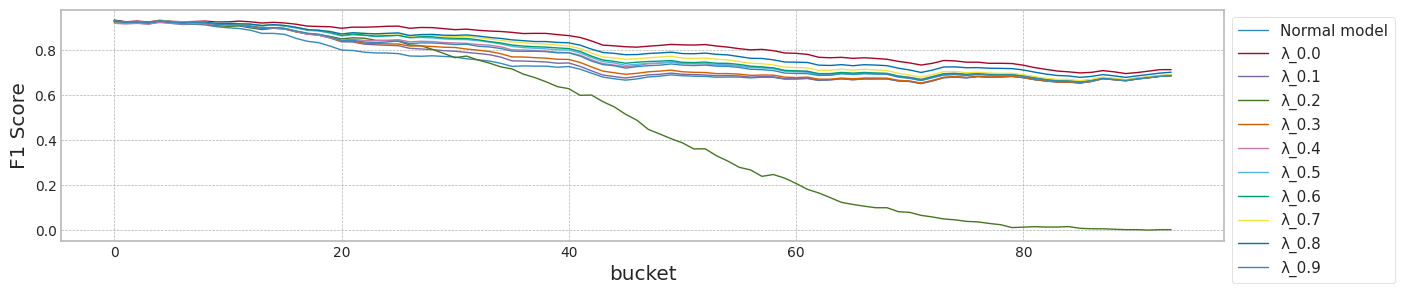

max_mean_lambda= 0.0


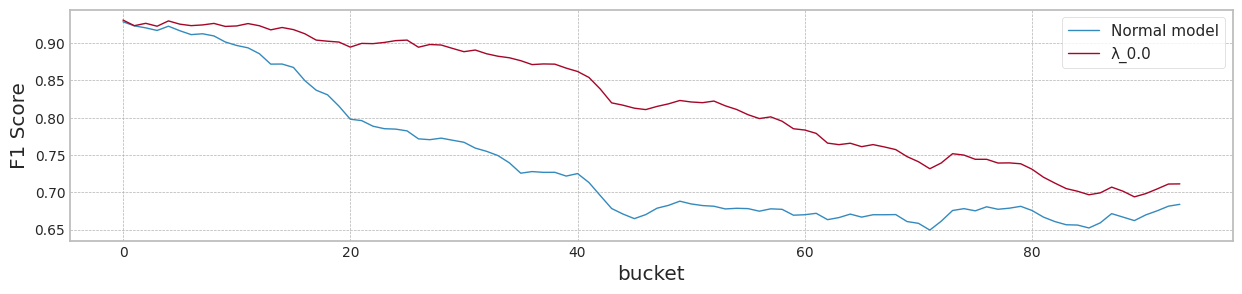

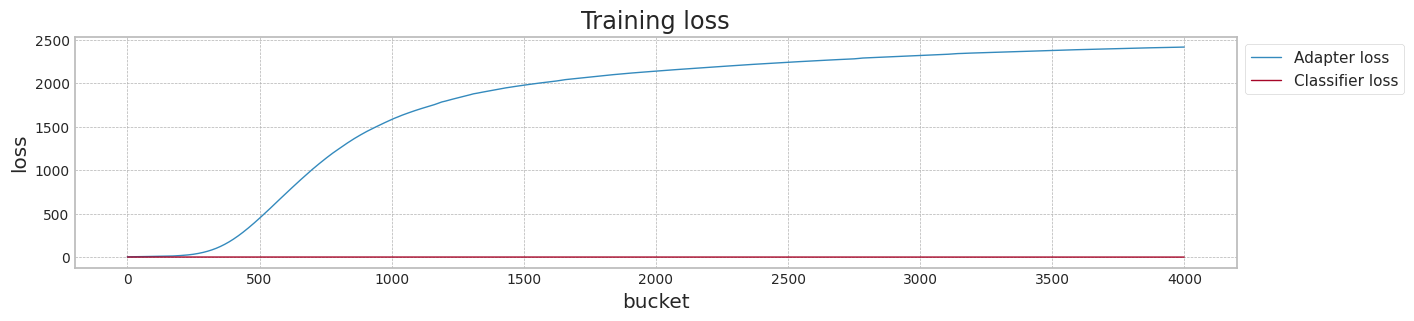

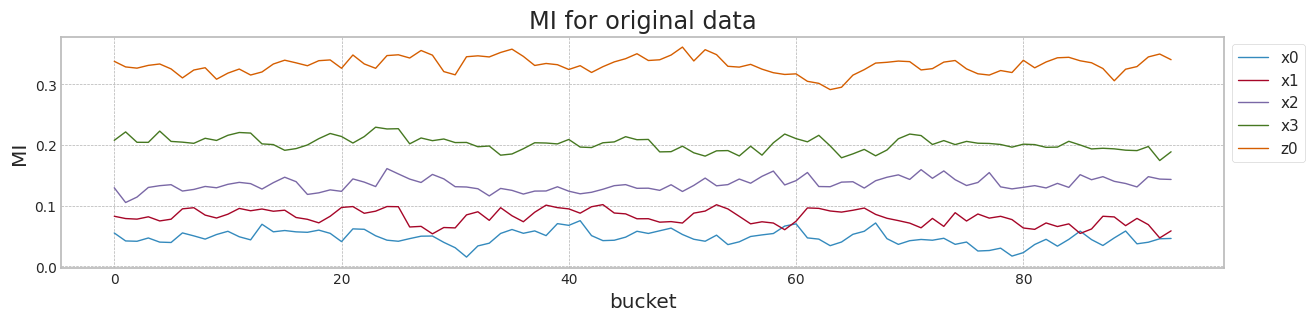

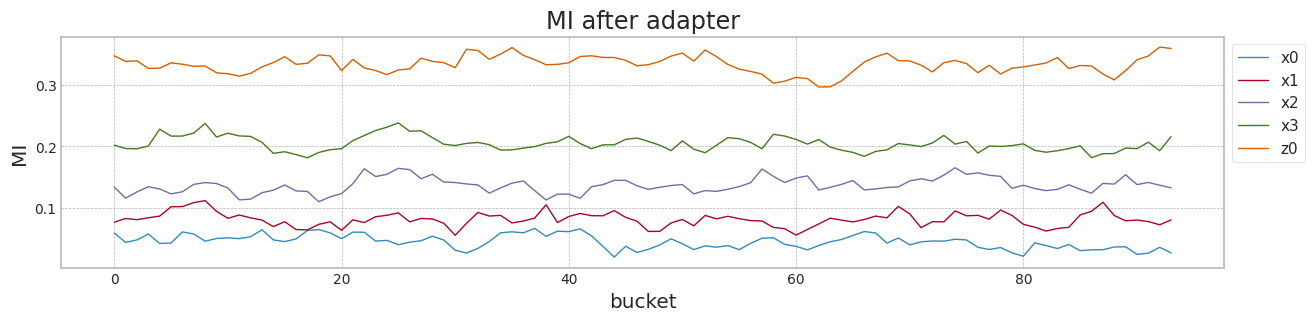

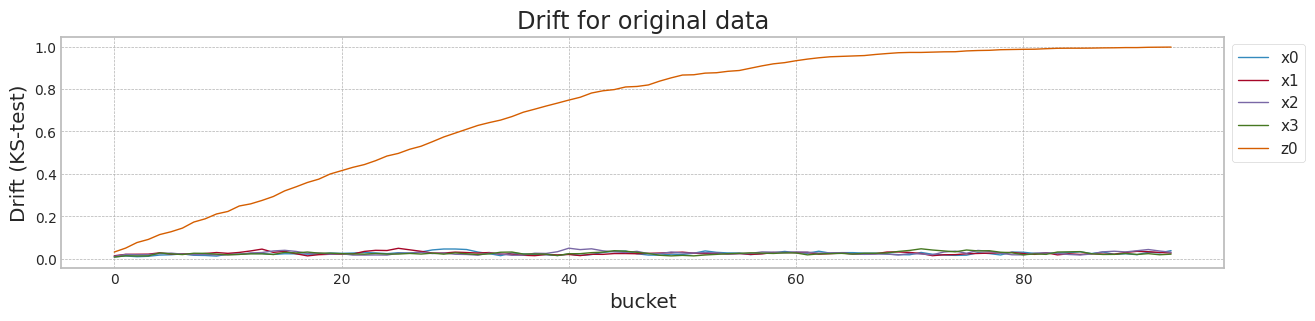

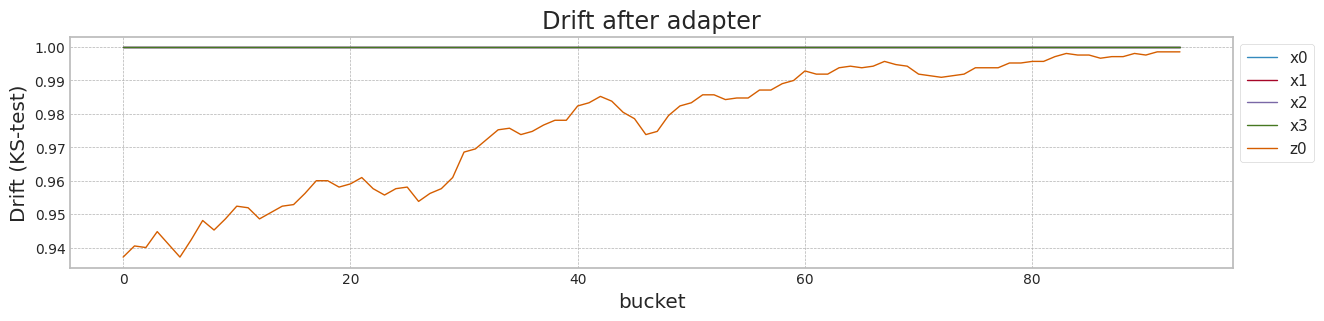

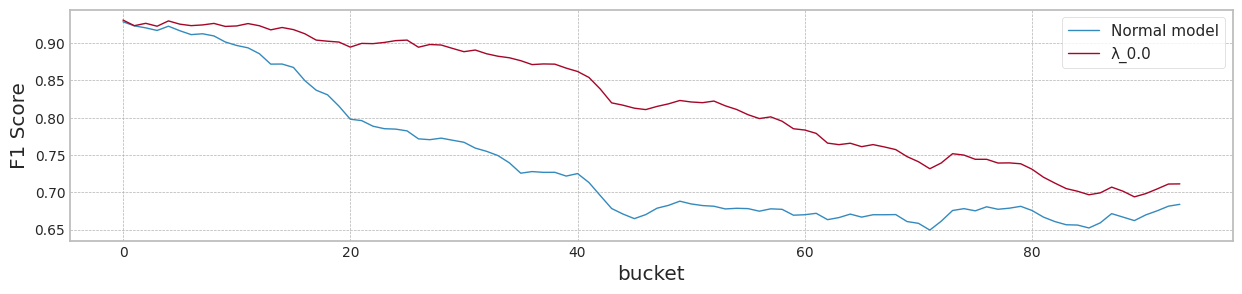

lambda   test_f1   init_f1   mean_f1   last_f1    sum mi  \
0   Case #1, Normal model  0.928539  0.928539  0.738041  0.683798  0.918580   
1                     0.0  0.930812  0.930812  0.824221  0.711213  0.932219   
2                     0.1  0.924284  0.924284  0.749079  0.683798  0.898242   
3                     0.2  0.922581  0.922581  0.462871  0.001832  0.898718   
4                     0.3  0.922935  0.922935  0.754807  0.683798  0.852562   
5                     0.4  0.916551  0.916551  0.770891  0.687461  0.887059   
6                     0.5  0.924208  0.924208  0.775814  0.685517  0.906980   
7                     0.6  0.926181  0.926181  0.779192  0.685517  0.918788   
8                     0.7  0.926316  0.926316  0.787512  0.688328  0.907329   
9                     0.8  0.926316  0.926316  0.799511  0.699583  0.893915   
10                    0.9  0.927364  0.927364  0.767578  0.685086  0.895191   

      std mi  sum * std   sum 1/2   std 1/2   sum 2/2   std 2/2   sum 1-2  \
0   0.129343   0.118812  0.960410  0.131364  0.841293  0.135456  0.119117   
1   0.120075   0.111936  0.972048  0.125583  0.875270  0.124177  0.096779   
2   0.128599   0.115513  0.932309  0.131367  0.854927  0.127344  0.077382   
3   0.127978   0.115016  0.903751  0.129423  0.869222  0.125766  0.034529   
4   0.131573   0.112174  0.892637  0.139896  0.843987  0.129264  0.048649   
5   0.128912   0.114353  0.935369  0.131194  0.848083  0.121823  0.087286   
6   0.128791   0.116811  0.933471  0.139110  0.835590  0.124869  0.097880   
7   0.128052   0.117653  0.930443  0.129876  0.830522  0.133277  0.099921   
8   0.133548   0.121172  0.920807  0.132134  0.835788  0.132501  0.085020   
9   0.130373   0.116543  0.913573  0.134888  0.833408  0.127310  0.080165   
10  0.128054   0.114632  0.922589  0.129910  0.852278  0.130468  0.070311   

     std 1-2   sum 1+2   std 1+2  
0   0.004091  1.801702  0.266820  
1   0.001406  1.847318  0.249759  
2   0.004022  1.787235  0.258711  
3   0.003657  1.772973  0.255189  
4   0.010632  1.736624  0.269160  
5   0.009372  1.783451  0.253017  
6   0.014241  1.769061  0.263980  
7   0.003401  1.760965  0.263153  
8   0.000367  1.756595  0.264634  
9   0.007578  1.746981  0.262198  
10  0.000558  1.774867  0.260378

In [83]:
drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b']+1))

## synthetic data의 생성 (Case #5 - Case #1,2,3,4의 상황이 각 feature에 혼재되어 있는 경우)

### Dataset 준비

In [84]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.5 , 0.7, 2.5])

x4 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x4[:,ix] = np.random.normal(1,cor_,data_size)

y4_array = []
cor_const = cor[4]
cor_const2 = 3/x4.shape[0]
for ii in range(x4.shape[0]):
    # Case #2, MI의 증감(상대적), Drift의 고정 - z0
    cor[4] = cor[4] - cor_const / x4.shape[0]
    e = np.random.normal(0.0, 2.0)
    # Case #3 MI의 증감(상대적), Drift의 증가 - x3
    e1 = np.random.normal(0.0, 3*cor_const2 * ii)
    x4[ii,3] = x4[ii,3] + e1
    y4_array.append(np.sum(cor * x4[ii])+e)

y4 = [1 if y_ > 5 else 0 for y_ in y4_array]

for i in range(len(y4)):
    #Case #1 MI의 감소, Drift의 증가 - x2
    x4[i,2] = y4[i] + np.random.normal(1,0.5+(i/data_size))
    #Case #4 MI의 고정, Drift의 증가 - x1
    x4[i,1] = y4[i] + np.random.normal(0.0 + 4*(i/data_size),cor[1])


### 실험

MI Analysis MI Max 0.14553, Min 0.02498, Mean 0.08409, Std 0.04454
Dataset structure X_train, (2100, 5) X_test, (2100, 5) X_live (39600, 5)
Truncate 6000 rows from live_set (39600, 5)
Search MI & Drift...for X_live_set (94, 2100, 5)


100%|██████████| 94/94 [00:03<00:00, 23.81it/s]


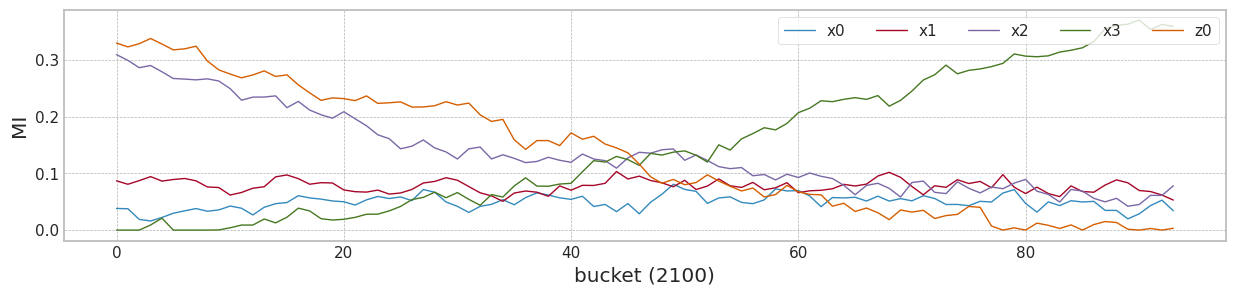

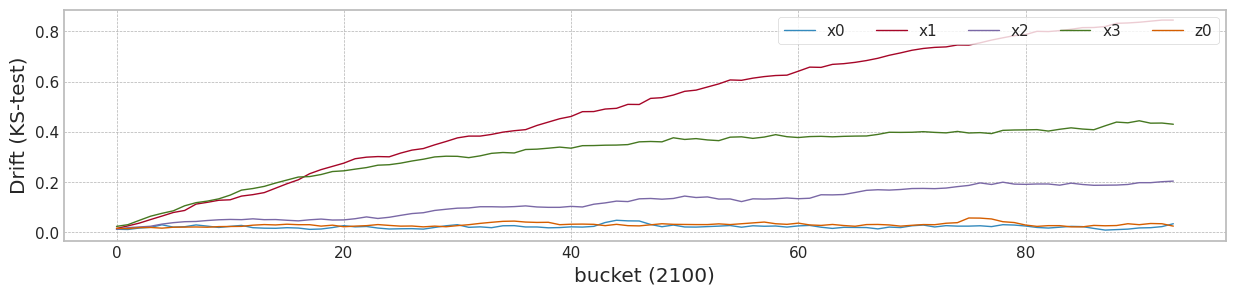

In [85]:
columns=['x0','x1','x2','x3','z0']
X4 = pd.DataFrame(x4,columns=columns)

train_size = 2100
test_size = 400

X1,Y1 = check_mi_drift(X4, y4,train_size, test_size)

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:05<00:00, 688.41it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9459677419354839
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 22.54it/s]


mean of drift:
x0    0.022842
x1    0.496130
x2    0.119448
x3    0.317067
z0    0.030664
dtype: float64
Mean F1 for all data: 0.7476662635658872
######################### Lambda 0.0 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 239.96it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9532403609515996
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 22.33it/s]


mean of drift:
x0    0.999899
x1    0.895005
x2    0.998673
x3    1.000000
z0    0.538941
dtype: float64
Mean F1 for all data: 0.8292040657876426
######################### Lambda 0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 239.03it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9522253981216824
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 22.26it/s]


mean of drift:
x0    0.722280
x1    0.436849
x2    0.667619
x3    0.791383
z0    0.251049
dtype: float64
Mean F1 for all data: 0.445591016929001
######################### Lambda 0.2 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 236.99it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9471114727420668
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 21.89it/s]


mean of drift:
x0    0.553794
x1    0.168652
x2    0.587660
x3    0.504169
z0    0.308754
dtype: float64
Mean F1 for all data: 0.47236797463592023
######################### Lambda 0.3 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 241.64it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9464285714285714
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 20.60it/s]


mean of drift:
x0    0.625431
x1    0.320476
x2    0.475182
x3    0.411869
z0    0.298465
dtype: float64
Mean F1 for all data: 0.595505241936572
######################### Lambda 0.4 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 242.06it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9429380817482801
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 21.77it/s]


mean of drift:
x0    0.082558
x1    0.316484
x2    0.507163
x3    0.364032
z0    0.299139
dtype: float64
Mean F1 for all data: 0.6210613537065336
######################### Lambda 0.5 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 236.99it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9422222222222222
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 21.90it/s]


mean of drift:
x0    0.476469
x1    0.321388
x2    0.398855
x3    0.351251
z0    0.371023
dtype: float64
Mean F1 for all data: 0.5893213415413573
######################### Lambda 0.6 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 240.38it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9418886198547214
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 22.37it/s]


mean of drift:
x0    0.368531
x1    0.351302
x2    0.385963
x3    0.337553
z0    0.325420
dtype: float64
Mean F1 for all data: 0.5941075702121353
######################### Lambda 0.7 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 237.66it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9395648670427075
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 22.22it/s]


mean of drift:
x0    0.215674
x1    0.385005
x2    0.345071
x3    0.327903
z0    0.304169
dtype: float64
Mean F1 for all data: 0.6126711923241107
######################### Lambda 0.8 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 238.99it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9378259125551544
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 22.16it/s]


mean of drift:
x0    0.126707
x1    0.413425
x2    0.278136
x3    0.319184
z0    0.189838
dtype: float64
Mean F1 for all data: 0.6301206617309841
######################### Lambda 0.9 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 240.74it/s]


ty torch.Size([2100])
y_hat (2100, 1)
Test f1 score: 0.9356771873751498
X_live.shape (39600, 6)
Truncate 6000 rows from live_set (39600, 6)
Search MI & Drift...for X_live_set torch.Size([94, 2100, 6])


100%|██████████| 94/94 [00:04<00:00, 21.68it/s]


mean of drift:
x0    0.102123
x1    0.444559
x2    0.184063
x3    0.313658
z0    0.155334
dtype: float64
Mean F1 for all data: 0.6489708977659459


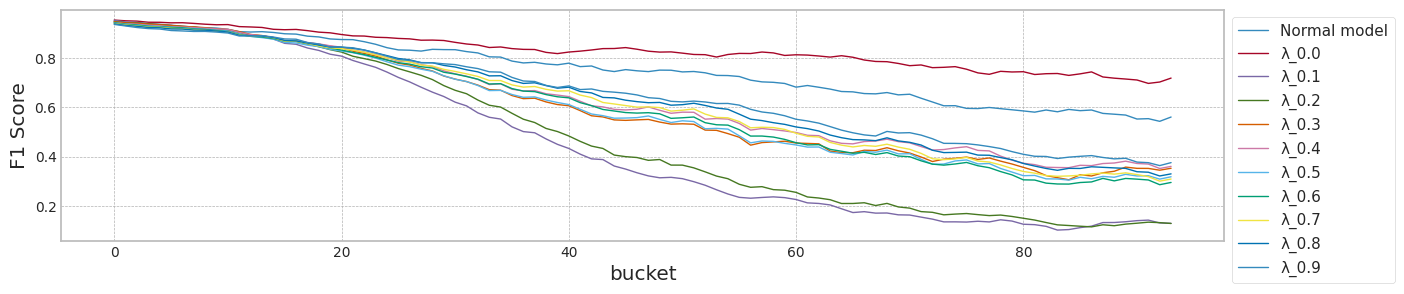

max_mean_lambda= 0.0


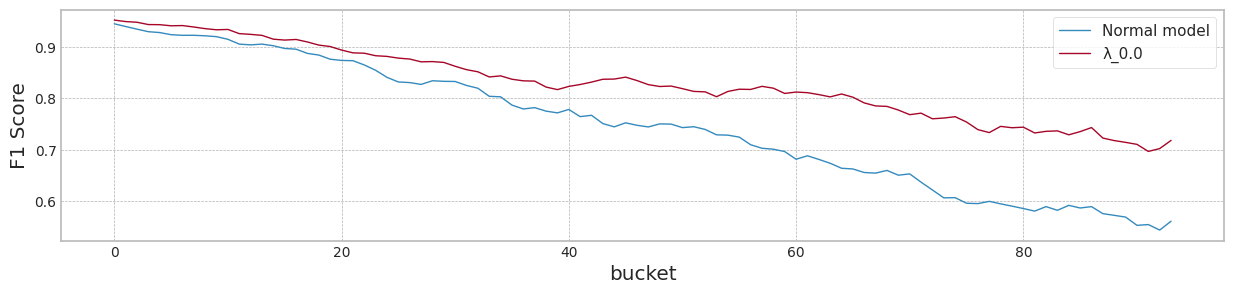

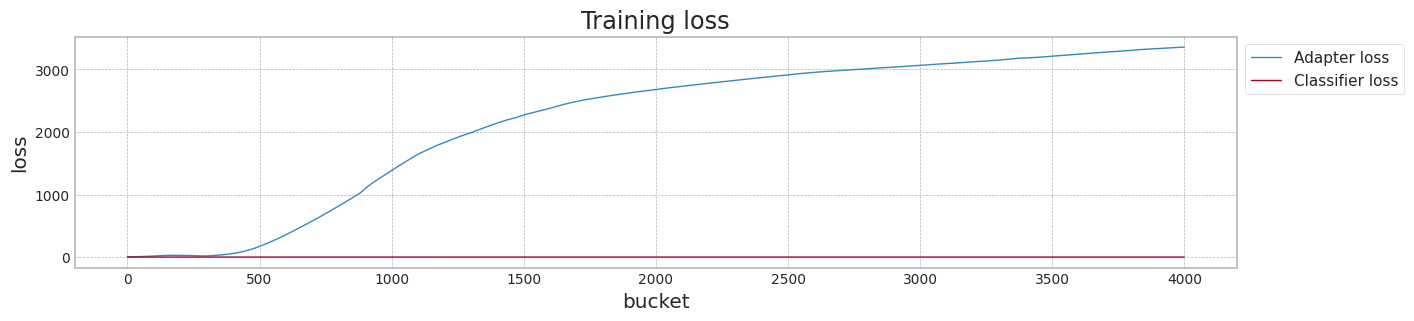

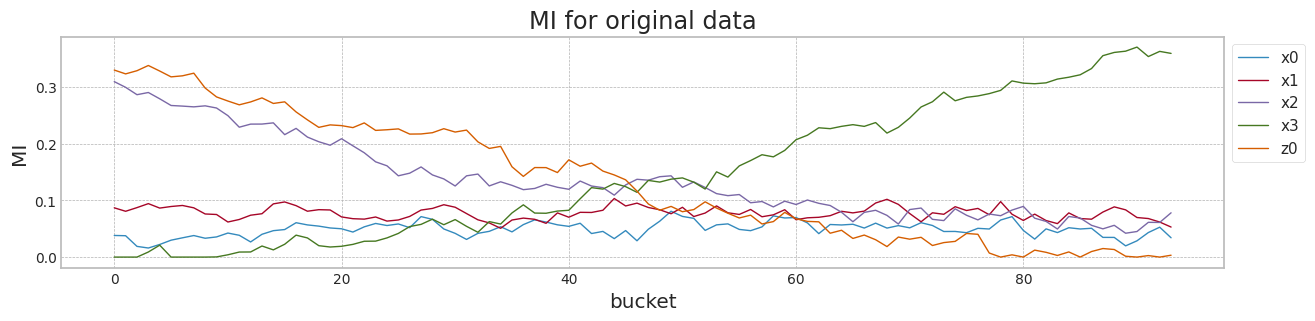

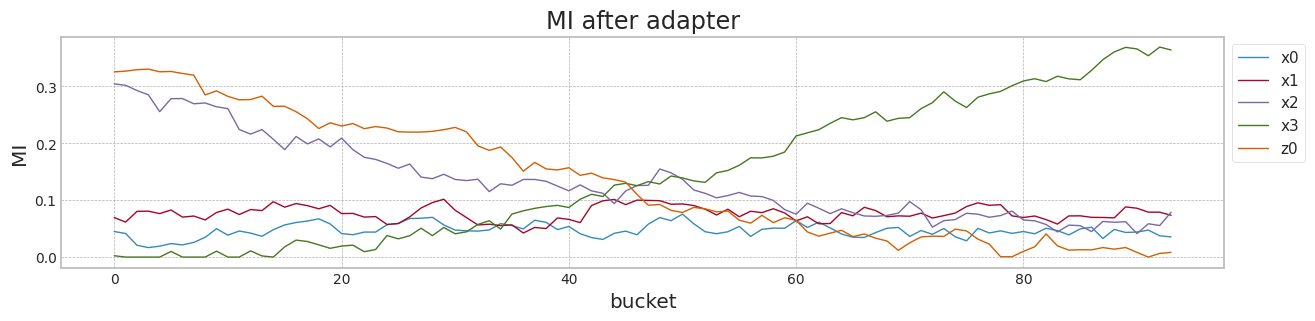

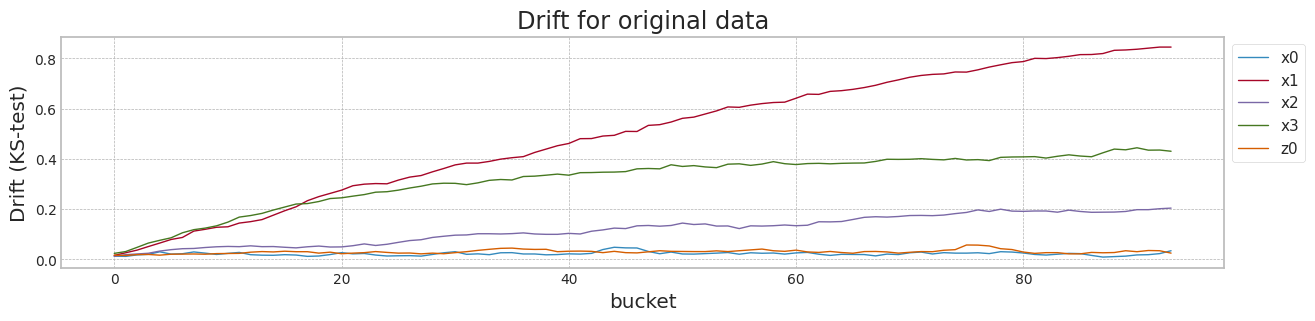

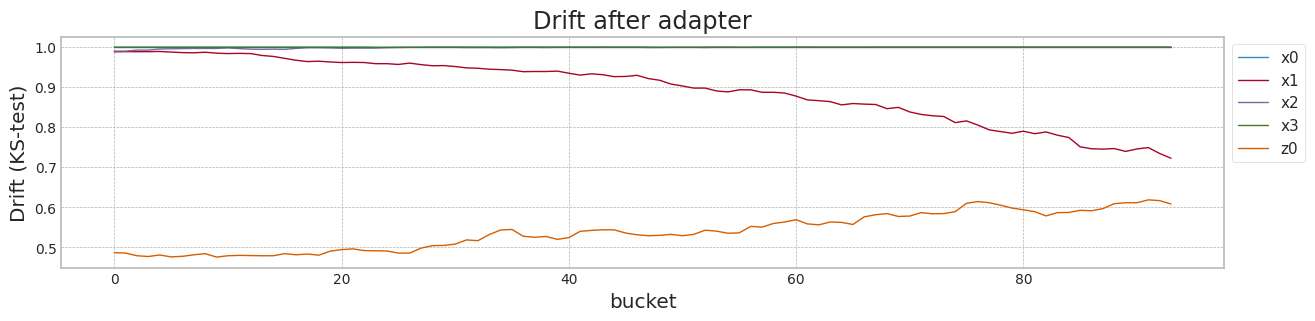

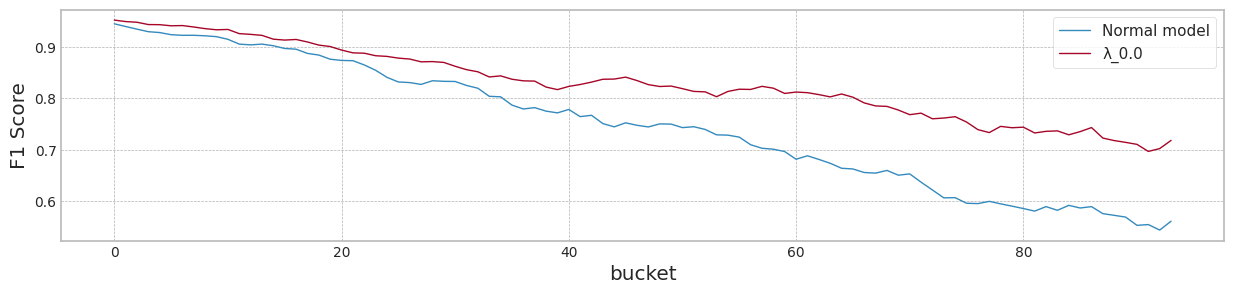

lambda   test_f1   init_f1   mean_f1   last_f1    sum mi  \
0   Case #1, Normal model  0.945968  0.945968  0.747666  0.560105  0.806989   
1                     0.0  0.953240  0.953240  0.829204  0.718016  0.794456   
2                     0.1  0.952225  0.952225  0.445591  0.128966  0.819561   
3                     0.2  0.947111  0.947111  0.472368  0.128514  0.827747   
4                     0.3  0.946429  0.946429  0.595505  0.352396  0.814508   
5                     0.4  0.942938  0.942938  0.621061  0.359973  0.818982   
6                     0.5  0.942222  0.942222  0.589321  0.317872  0.807715   
7                     0.6  0.941889  0.941889  0.594108  0.294837  0.840649   
8                     0.7  0.939565  0.939565  0.612671  0.308657  0.810454   
9                     0.8  0.937826  0.937826  0.630121  0.329609  0.828198   
10                    0.9  0.935677  0.935677  0.648971  0.375186  0.821945   

      std mi  sum * std   sum 1/2   std 1/2   sum 2/2   std 2/2   sum 1-2  \
0   0.155717   0.125662  0.795964  0.156137  0.830775  0.151459  0.034812   
1   0.148855   0.118259  0.751071  0.147593  0.841704  0.155553  0.090633   
2   0.157053   0.128714  0.800410  0.152419  0.851944  0.156388  0.051535   
3   0.158059   0.130833  0.813880  0.157642  0.843585  0.162478  0.029705   
4   0.164498   0.133985  0.791911  0.160469  0.818842  0.162550  0.026931   
5   0.156048   0.127801  0.809242  0.159044  0.838446  0.162329  0.029204   
6   0.159928   0.129176  0.786178  0.162614  0.843647  0.159019  0.057469   
7   0.156087   0.131214  0.806200  0.160146  0.850025  0.156400  0.043825   
8   0.155282   0.125849  0.790394  0.159222  0.833690  0.159018  0.043296   
9   0.152772   0.126526  0.791998  0.153634  0.837102  0.151893  0.045104   
10  0.152219   0.125116  0.776958  0.150182  0.836880  0.148806  0.059922   

     std 1-2   sum 1+2   std 1+2  
0   0.004678  1.626739  0.307596  
1   0.007960  1.592776  0.303145  
2   0.003969  1.652354  0.308807  
3   0.004836  1.657466  0.320119  
4   0.002082  1.610752  0.323019  
5   0.003285  1.647688  0.321372  
6   0.003595  1.629825  0.321633  
7   0.003746  1.656225  0.316547  
8   0.000204  1.624084  0.318240  
9   0.001740  1.629100  0.305527  
10  0.001375  1.613837  0.298988

In [86]:
bucket_size = 700
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b'])+1)


## real-world data 의 실험

### Loan data 실험

#### Dataset 준비

##### Data load

In [1]:

if True:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [18]:

df_accepted = pd.read_csv("/content/drive/MyDrive/Drift/accepted_2007_to_2018Q4.csv")

print(df_accepted.shape)

(2260701, 151)


##### Data 정제

In [19]:
# for the sake of simplicity, let's consider only Fully Paid and Charged Off values:
df_accepted = df_accepted[df_accepted.loan_status.isin(['Fully Paid', 'Charged Off'])]
print(df_accepted.shape)

cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(50).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# maybe we can go further, and eliminate columns up to title:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(45).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# Remaining columns have missing data points, but they account for less than 0.2% of the total data. Let's remove the rows that are missing those values in those columns with dropna():
df_accepted = df_accepted.dropna()
print(df_accepted.shape)

# These are constant columns. We can drop it either.
cols_to_drop = ['out_prncp', 'out_prncp_inv', 'policy_code']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# It seems we have many "duplicated" information. Let's drop some columns, based on visual inspection at corr_pairs dataframe:
cols_to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

values = df_accepted.loan_status.unique()
encode = [1,0]
d = dict(zip(values, encode))
df_accepted['loan_paid'] = df_accepted['loan_status'].map(d)
df_accepted = df_accepted.drop(columns=['loan_status'])

df_accepted

(1345310, 151)
(1345310, 101)
(1345310, 56)
(1341026, 56)
(1341026, 53)
(1341026, 44)


id  loan_amnt        term  int_rate grade sub_grade  \
0        68407277     3600.0   36 months     13.99     C        C4   
1        68355089    24700.0   36 months     11.99     C        C1   
2        68341763    20000.0   60 months     10.78     B        B4   
4        68476807    10400.0   60 months     22.45     F        F1   
5        68426831    11950.0   36 months     13.44     C        C3   
...           ...        ...         ...       ...   ...       ...   
2260688  89905081    18000.0   60 months      9.49     B        B2   
2260690  88948836    29400.0   60 months     13.99     C        C3   
2260691  89996426    32000.0   60 months     14.49     C        C4   
2260692  90006534    16000.0   60 months     12.79     C        C1   
2260697  88224441    24000.0   60 months     14.49     C        C4   

        home_ownership  annual_inc verification_status   issue_d  ...  \
0             MORTGAGE     55000.0        Not Verified  Dec-2015  ...   
1             MORTGAGE     65000.0        Not Verified  Dec-2015  ...   
2             MORTGAGE     63000.0        Not Verified  Dec-2015  ...   
4             MORTGAGE    104433.0     Source Verified  Dec-2015  ...   
5                 RENT     34000.0     Source Verified  Dec-2015  ...   
...                ...         ...                 ...       ...  ...   
2260688            OWN    130000.0        Not Verified  Oct-2016  ...   
2260690       MORTGAGE    180792.0        Not Verified  Oct-2016  ...   
2260691       MORTGAGE    157000.0     Source Verified  Oct-2016  ...   
2260692           RENT    150000.0        Not Verified  Oct-2016  ...   
2260697           RENT    110000.0        Not Verified  Oct-2016  ...   

        application_type acc_now_delinq chargeoff_within_12_mths delinq_amnt  \
0             Individual            0.0                      0.0         0.0   
1             Individual            0.0                      0.0         0.0   
2              Joint App            0.0                      0.0         0.0   
4             Individual            0.0                      0.0         0.0   
5             Individual            0.0                      0.0         0.0   
...                  ...            ...                      ...         ...   
2260688       Individual            0.0                      0.0         0.0   
2260690       Individual            0.0                      0.0         0.0   
2260691       Individual            0.0                      0.0         0.0   
2260692       Individual            0.0                      0.0         0.0   
2260697       Individual            0.0                      0.0         0.0   

        pub_rec_bankruptcies  tax_liens  hardship_flag disbursement_method  \
0                        0.0        0.0              N                Cash   
1                        0.0        0.0              N                Cash   
2                        0.0        0.0              N                Cash   
4                        0.0        0.0              N                Cash   
5                        0.0        0.0              N                Cash   
...                      ...        ...            ...                 ...   
2260688                  0.0        0.0              N                Cash   
2260690                  0.0        0.0              N                Cash   
2260691                  0.0        0.0              N                Cash   
2260692                  3.0        0.0              N                Cash   
2260697                  1.0        0.0              N                Cash   

         debt_settlement_flag  loan_paid  
0                           N          1  
1                           N          1  
2                           N          1  
4                           N          1  
5                           N          1  
...                       ...        ...  
2260688                     N          1  
2260690                     N          1  
2260691     

In [20]:
# droping constant columns
print(df_accepted.pymnt_plan.value_counts())
print(df_accepted.hardship_flag.value_counts())
cols_to_drop = ['id', 'pymnt_plan', 'hardship_flag']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

print(df_accepted.term.value_counts())

# convert term into either a 36 or 60 integer numeric data type

l1 = df_accepted.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))

df_accepted['term'] = df_accepted['term'].map(d)

# as grade is part of sub_grade, so let's just drop the grade feature.

df_accepted = df_accepted.drop(columns='grade')

df_accepted = pd.get_dummies(df_accepted, columns = ['sub_grade'], prefix='', prefix_sep='', drop_first=True)

cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

# for these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.

df_accepted = pd.get_dummies(df_accepted, columns = ['verification_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['application_type'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['initial_list_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['purpose'], prefix='', prefix_sep='', drop_first=True)
print(df_accepted.shape)

df_accepted['home_ownership'] = df_accepted.home_ownership.replace('NONE', 'ANY')
df_accepted = pd.get_dummies(df_accepted, columns = ['home_ownership'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=[ 'url', 'last_pymnt_d', 'last_credit_pull_d'])
df_accepted = df_accepted.drop(columns=['zip_code', 'addr_state'])
df_accepted = pd.get_dummies(df_accepted, columns = ['disbursement_method'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['debt_settlement_flag'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=['earliest_cr_line'])
print(df_accepted.shape)


df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jan','01')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Feb','02')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Mar','03')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Apr','04')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('May','05')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jun','06')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jul','07')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Aug','08')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Sep','09')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Oct','10')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Dec','11')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Nov','12')

def reorder_issue_d(dt):
    a = dt.split('-')
    return a[1]+a[0]

reorder_issue_d('01-2009')

df_accepted['issue_d'] = df_accepted['issue_d'].apply(reorder_issue_d)
df_accepted = df_accepted.sort_values(by='issue_d')
df_accepted.reset_index(drop=True, inplace=True)

df_accepted.info()

n    1341026
Name: pymnt_plan, dtype: int64
N    1341026
Name: hardship_flag, dtype: int64
(1341026, 41)
Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'url', 'purpose', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')
 36 months    1017398
 60 months     323628
Name: term, dtype: int64
Index(['home_ownership', 'verification_status', 'issue_d', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')
(1341026, 86)
(1341026, 83)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341026 entries, 0 to 1341025
Data columns (total 83 columns):
 #   Column                      Non-Null Count    Dtype  

##### Dataset 만들기

In [21]:
X = {}
Y = {}

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
df = df.drop(columns=['issue_d'])


X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values


for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values

2010
2011
2012
2013
2014
2015
2016
2017
2018


In [22]:

X[2010].shape

(11497, 81)

In [23]:
COLUMNS = df.loc[:, df.columns != 'loan_paid'].columns
COLUMNS

Index(['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'last_pymnt_amnt', 'last_fico_range_high',
       'collections_12_mths_ex_med', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies',
       'tax_liens', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1',
       'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3',
       'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5',
       'Source Verified', 'Verified', 'Joint App', 'w', 'credit_card',
       'debt_consolidation', 'educational', 'home_improvement', 'house',
       'major_purchase', 'medical', 'moving', 'other', 'renewable_energy',
       'small_business', 'vacation', 'wedding', 'MORTGAGE', 'OTHER', 'OWN',
       'RENT', 'DirectPay', 'Y'],
      dtype

In [24]:
X_df = pd.DataFrame(X[2010],columns=COLUMNS)
mi_scores = make_mi_scores(X_df, Y[2010], discrete_features="auto")
print(mi_scores)

recoveries              0.375513
last_fico_range_high    0.093789
last_pymnt_amnt         0.085796
total_rec_late_fee      0.037337
term                    0.014050
                          ...   
revol_util              0.000000
A3                      0.000000
F4                      0.000000
F2                      0.000000
F5                      0.000000
Name: MI Scores, Length: 81, dtype: float64


In [25]:
# MI Top 5, columns
top_columns = list(mi_scores[0:5].index)
top_columns

['recoveries',
 'last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'term']

+ 일부러 예측 확률을 떨어뜨리기 위해 (조정), "recoveries" feature를 제외 한다.

In [26]:
top_columns = list(mi_scores[1:10].index)
top_columns

['last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'term',
 'int_rate',
 'annual_inc',
 'debt_consolidation',
 'Y',
 'RENT']

In [27]:
top_columns_index = [list(COLUMNS).index(tc) for tc in top_columns]
top_columns_index

[17, 16, 14, 1, 2, 3, 63, 80, 78]

In [28]:
# 2010년의 data를 기준으로 그 이후의 data 들...
X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2 = pd.DataFrame(X2,columns = COLUMNS)[top_columns]
#X2_df_t5 = X2_df[top_columns]

#### 실험

MI Analysis MI Max 0.31575, Min 0.00452, Mean 0.11437, Std 0.10347
Dataset structure X_train, (10000, 9) X_test, (10000, 9) X_live (1278183, 9)
Truncate 28665 rows from live_set (1278183, 9)
Search MI & Drift...for X_live_set (848, 10000, 9)


100%|██████████| 848/848 [05:01<00:00,  2.82it/s]


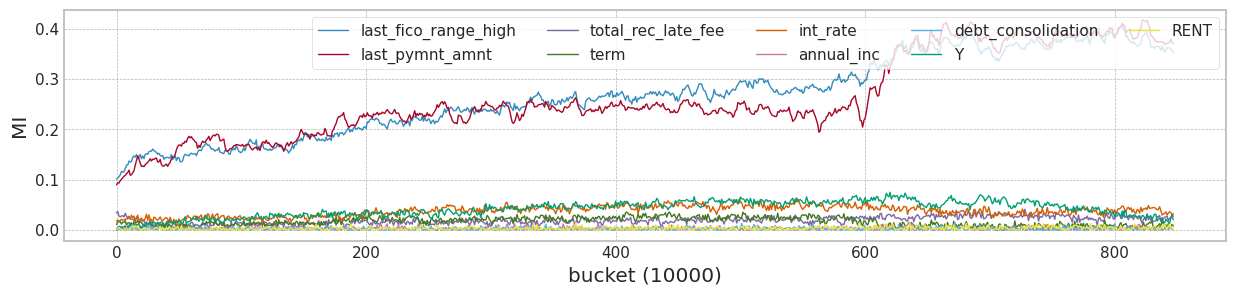

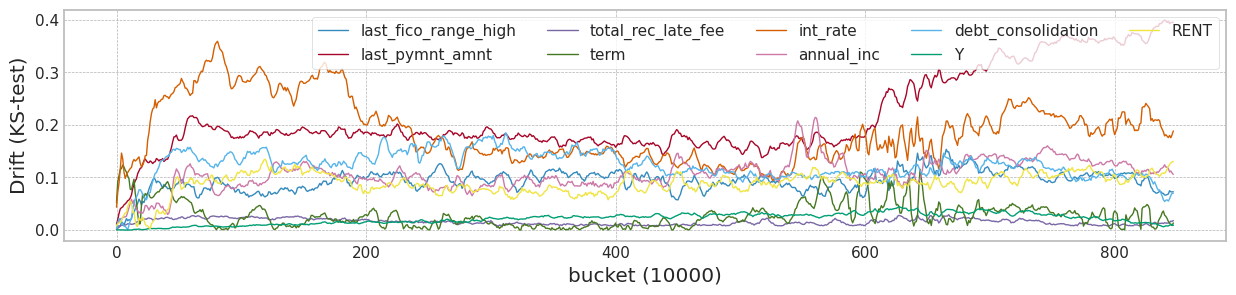

In [29]:
train_size = 10000
test_size = 1497

X1,Y1 = check_mi_drift(X2, Y2, train_size, test_size)

In [30]:
X1['b'] = [int(b/5000) for b in X1.index.values]
X1

last_fico_range_high  last_pymnt_amnt  total_rec_late_fee  term  \
0                    0.928910         0.032896            0.000000   0.0   
1                    0.863744         0.010440            0.000000   0.0   
2                    0.727488         0.381296            0.000000   0.0   
3                    0.869668         0.021731            0.000000   0.0   
4                    0.952607         0.027513            0.000000   0.0   
...                       ...              ...                 ...   ...   
1279675              0.917062         0.000269            0.090128   0.0   
1279676              0.857820         0.403841            0.000000   0.0   
1279677              0.905213         0.334665            0.000000   0.0   
1279678              0.922986         0.971979            0.000000   0.0   
1279679              0.881517         0.377212            0.000000   1.0   

         int_rate  annual_inc  debt_consolidation    Y  RENT    b  
0        0.502466    0.006324                 1.0  0.0   1.0    0  
1        0.416769    0.003656                 1.0  0.0   1.0    0  
2        0.566584    0.009727                 0.0  0.0   0.0    0  
3        0.652281    0.015330                 1.0  0.0   1.0    0  
4        0.395191    0.016831                 1.0  0.0   0.0    0  
...           ...         ...                 ...  ...   ...  ...  
1279675  0.278052    0.014330                 0.0  0.0   1.0  255  
1279676  0.278052    0.024337                 0.0  0.0   0.0  255  
1279677  0.157213    0.006074                 0.0  0.0   1.0  255  
1279678 -0.006165    0.006825                 1.0  0.0   0.0  255  
1279679  1.564118    0.003322                 1.0  0.0   1.0  255  

[1279680 rows x 10 columns]

In [31]:
a = np.asarray([1,2,3,4,5,6])
a[:-1]

array([1, 2, 3, 4, 5])

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 654.67it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9360134366365064
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [05:06<00:00,  2.77it/s]


mean of drift:
last_fico_range_high    0.117682
last_pymnt_amnt         0.214501
total_rec_late_fee      0.019389
term                    0.028391
int_rate                0.187503
annual_inc              0.125111
debt_consolidation      0.123044
Y                       0.021749
RENT                    0.088541
dtype: float64
Mean F1 for all data: 0.9188329675370069
######################### Lambda 0.0 ###########################
cuda:0


100%|██████████| 4000/4000 [00:23<00:00, 171.97it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9303668841587335
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [05:01<00:00,  2.81it/s]


mean of drift:
last_fico_range_high    0.999600
last_pymnt_amnt         0.985942
total_rec_late_fee      0.983312
term                    0.769016
int_rate                0.770635
annual_inc              1.000000
debt_consolidation      0.538100
Y                       0.972673
RENT                    0.513900
dtype: float64
Mean F1 for all data: 0.8879347926553869
######################### Lambda 0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:23<00:00, 169.89it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9437301719819671
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [05:02<00:00,  2.81it/s]


mean of drift:
last_fico_range_high    0.378919
last_pymnt_amnt         0.565824
total_rec_late_fee      0.991846
term                    0.756944
int_rate                0.824177
annual_inc              0.952786
debt_consolidation      0.464801
Y                       0.995364
RENT                    0.598295
dtype: float64
Mean F1 for all data: 0.9074003565374825
######################### Lambda 0.2 ###########################
cuda:0


100%|██████████| 4000/4000 [00:23<00:00, 171.13it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9430516353976424
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [05:00<00:00,  2.82it/s]


mean of drift:
last_fico_range_high    0.852670
last_pymnt_amnt         0.500278
total_rec_late_fee      0.990338
term                    0.758503
int_rate                0.484594
annual_inc              0.987373
debt_consolidation      0.464187
Y                       0.993100
RENT                    0.596762
dtype: float64
Mean F1 for all data: 0.8890449172926949
######################### Lambda 0.3 ###########################
cuda:0


100%|██████████| 4000/4000 [00:23<00:00, 169.72it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9426351463051743
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [05:00<00:00,  2.82it/s]


mean of drift:
last_fico_range_high    0.762710
last_pymnt_amnt         0.518192
total_rec_late_fee      0.989939
term                    0.759142
int_rate                0.263556
annual_inc              0.990842
debt_consolidation      0.464187
Y                       0.992614
RENT                    0.535111
dtype: float64
Mean F1 for all data: 0.8889682673750129
######################### Lambda 0.4 ###########################
cuda:0


100%|██████████| 4000/4000 [00:23<00:00, 171.01it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9420552534739386
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [05:00<00:00,  2.82it/s]


mean of drift:
last_fico_range_high    0.519988
last_pymnt_amnt         0.620579
total_rec_late_fee      0.989194
term                    0.758721
int_rate                0.238836
annual_inc              0.991670
debt_consolidation      0.464187
Y                       0.991202
RENT                    0.513900
dtype: float64
Mean F1 for all data: 0.8890450660026125
######################### Lambda 0.5 ###########################
cuda:0


100%|██████████| 4000/4000 [00:23<00:00, 170.73it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.941105571686846
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [05:00<00:00,  2.82it/s]


mean of drift:
last_fico_range_high    0.251734
last_pymnt_amnt         0.702662
total_rec_late_fee      0.989862
term                    0.759142
int_rate                0.166220
annual_inc              0.990515
debt_consolidation      0.464187
Y                       0.989850
RENT                    0.513900
dtype: float64
Mean F1 for all data: 0.8893166303129573
######################### Lambda 0.6 ###########################
cuda:0


100%|██████████| 4000/4000 [00:23<00:00, 169.72it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9399683181296773
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [05:00<00:00,  2.82it/s]


mean of drift:
last_fico_range_high    0.697231
last_pymnt_amnt         0.655214
total_rec_late_fee      0.954569
term                    0.758987
int_rate                0.205757
annual_inc              0.967826
debt_consolidation      0.480899
Y                       0.986684
RENT                    0.513900
dtype: float64
Mean F1 for all data: 0.8906328276186216
######################### Lambda 0.7 ###########################
cuda:0


100%|██████████| 4000/4000 [00:23<00:00, 169.45it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9384422794317748
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [05:00<00:00,  2.82it/s]


mean of drift:
last_fico_range_high    0.260117
last_pymnt_amnt         0.552092
total_rec_late_fee      0.985493
term                    0.759142
int_rate                0.234465
annual_inc              0.959644
debt_consolidation      0.505907
Y                       0.978010
RENT                    0.513900
dtype: float64
Mean F1 for all data: 0.8909625271639989
######################### Lambda 0.8 ###########################
cuda:0


100%|██████████| 4000/4000 [00:24<00:00, 165.51it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9370356309995118
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [05:00<00:00,  2.82it/s]


mean of drift:
last_fico_range_high    0.369736
last_pymnt_amnt         0.581953
total_rec_late_fee      0.990478
term                    0.758503
int_rate                0.256231
annual_inc              0.957265
debt_consolidation      0.537014
Y                       0.972314
RENT                    0.513900
dtype: float64
Mean F1 for all data: 0.9411952789086627
######################### Lambda 0.9 ###########################
cuda:0


100%|██████████| 4000/4000 [00:23<00:00, 169.47it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9375986072574942
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [05:01<00:00,  2.81it/s]


mean of drift:
last_fico_range_high    0.153937
last_pymnt_amnt         0.585065
total_rec_late_fee      0.973026
term                    0.746560
int_rate                0.234051
annual_inc              0.958380
debt_consolidation      0.538100
Y                       0.972314
RENT                    0.513900
dtype: float64
Mean F1 for all data: 0.905694709491022


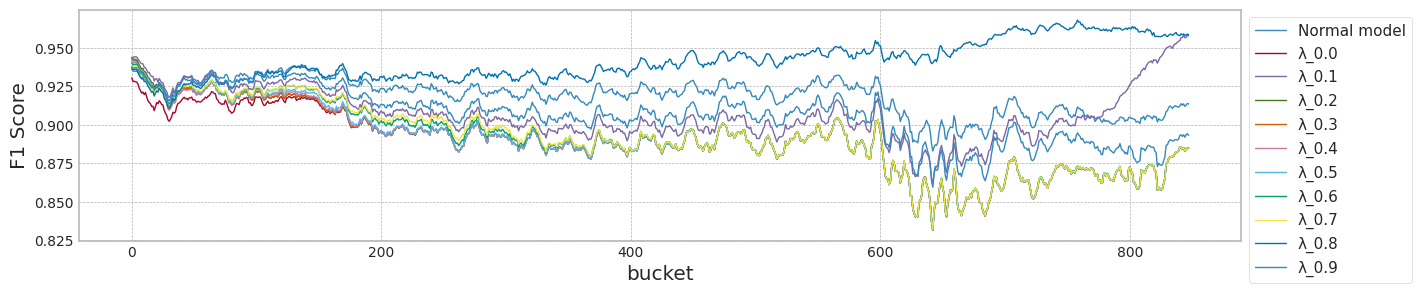

max_mean_lambda= 0.8


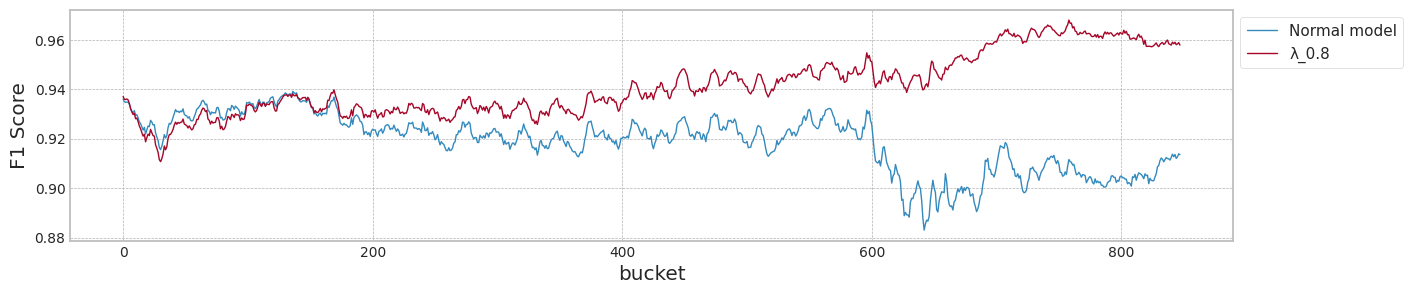

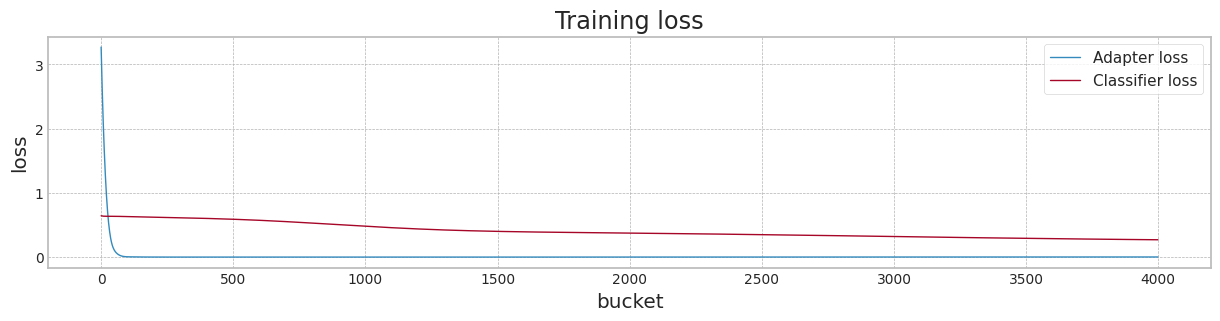

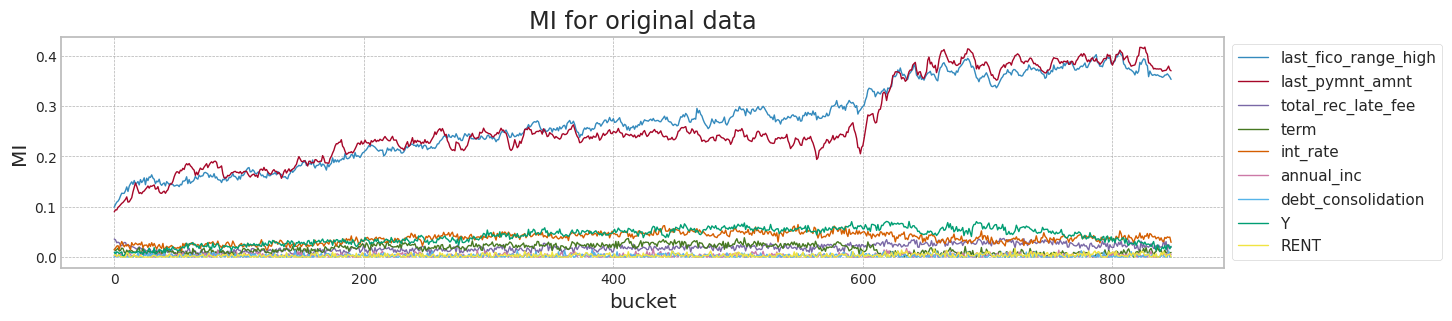

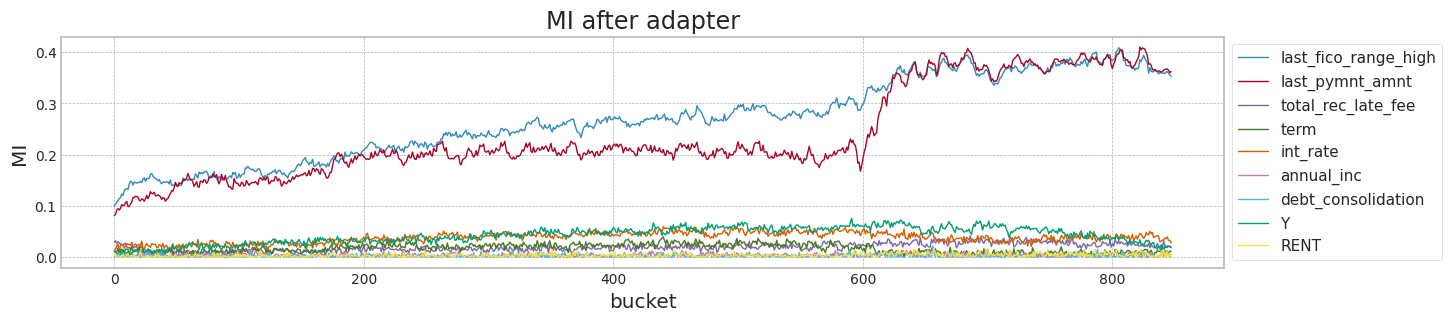

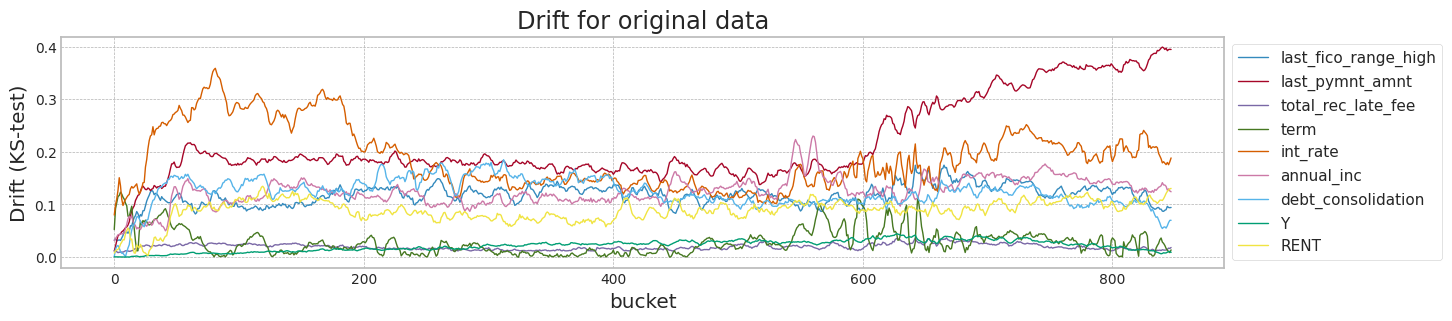

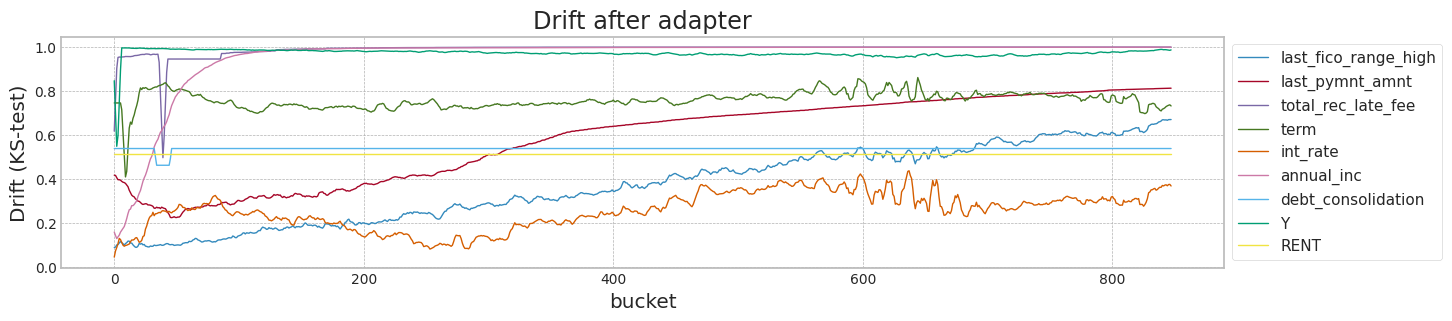

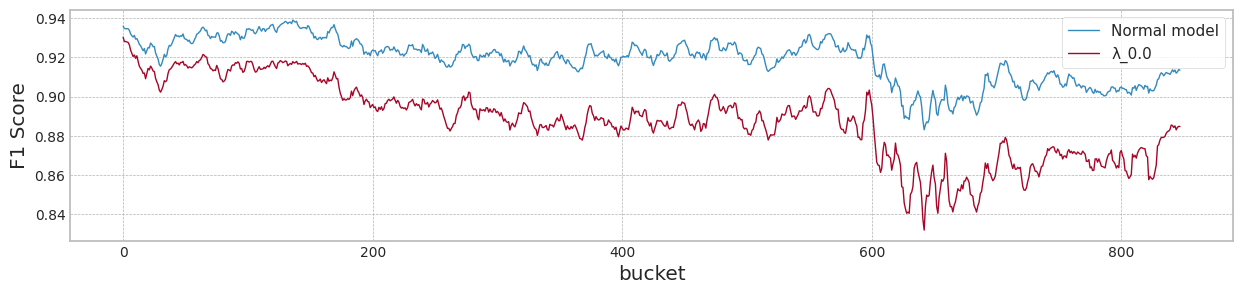

lambda   test_f1   init_f1   mean_f1   last_f1    sum mi  \
0   Case #1, Normal model  0.936013  0.936013  0.918833  0.913486  0.111638   
1                     0.0  0.930367  0.930367  0.887935  0.884675  0.003500   
2                     0.1  0.943730  0.943730  0.907400  0.958607  0.261841   
3                     0.2  0.943052  0.943052  0.889045  0.884675  0.245911   
4                     0.3  0.942635  0.942635  0.888968  0.884675  0.227176   
5                     0.4  0.942055  0.942055  0.889045  0.884675  0.209385   
6                     0.5  0.941106  0.941106  0.889317  0.884675  0.198480   
7                     0.6  0.939968  0.939968  0.890633  0.884972  0.178982   
8                     0.7  0.938442  0.938442  0.890963  0.884774  0.155800   
9                     0.8  0.937036  0.937036  0.941195  0.957804  0.129624   
10                    0.9  0.937599  0.937599  0.905695  0.893082  0.150516   

      std mi  sum * std   sum 1/2   std 1/2   sum 2/2   std 2/2   sum 1-2  \
0   0.011122   0.001242  0.103410  0.010266  0.124480  0.011168  0.021070   
1   0.000408   0.000001  0.003100  0.000435  0.002500  0.000336  0.000600   
2   0.033166   0.008684  0.245302  0.030324  0.289703  0.035290  0.044401   
3   0.029052   0.007144  0.224504  0.027634  0.269717  0.029415  0.045213   
4   0.025100   0.005702  0.200843  0.022943  0.253944  0.024710  0.053102   
5   0.021705   0.004545  0.186380  0.021478  0.239162  0.021548  0.052782   
6   0.019263   0.003823  0.183516  0.019064  0.222616  0.019399  0.039100   
7   0.016597   0.002971  0.168698  0.016877  0.199344  0.017413  0.030646   
8   0.014270   0.002223  0.151345  0.014645  0.167312  0.013298  0.015967   
9   0.011542   0.001496  0.124989  0.011642  0.143501  0.011584  0.018512   
10  0.013831   0.002082  0.145092  0.013967  0.163968  0.013563  0.018876   

     std 1-2   sum 1+2   std 1+2  
0   0.000902  0.227890  0.021433  
1   0.000099  0.005600  0.000771  
2   0.004966  0.535004  0.065614  
3   0.001781  0.494221  0.057048  
4   0.001767  0.454787  0.047654  
5   0.000070  0.425543  0.043026  
6   0.000335  0.406132  0.038462  
7   0.000536  0.368042  0.034290  
8   0.001347  0.318657  0.027944  
9   0.000059  0.268489  0.023226  
10  0.000404  0.309060  0.027530

In [33]:
drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 300) # np.max(X1['b'])+1)

### Card data 실험

#### Dataset 준비

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [ ]:
!kaggle datasets download "ealtman2019/credit-card-transactions"

 95% 249M/263M [00:02<00:00, 105MB/s]
100% 263M/263M [00:02<00:00, 112MB/s]


In [ ]:
!unzip credit-card-transactions.zip

Archive:  credit-card-transactions.zip
  inflating: User0_credit_card_transactions.csv  
  inflating: credit_card_transactions-ibm_v2.csv  
  inflating: sd254_cards.csv         
  inflating: sd254_users.csv         


In [ ]:
df = pd.read_csv("credit_card_transactions-ibm_v2.csv")

In [ ]:
df['Year'].value_counts()

2019    1723938
2017    1723360
2018    1721615
2016    1708924
2015    1701371
2014    1672343
2013    1650917
2012    1610829
2011    1570551
2010    1491225
2009    1355434
2008    1223460
2007    1064483
2006     908793
2005     746653
2004     597003
2003     466408
2002     350732
2020     336500
2001     257998
2000     177729
1999     118250
1998      78345
1997      49753
1996      29945
1995      20928
1994      14316
1993       8378
1992       5134
1991       1585
Name: Year, dtype: int64

In [ ]:
import lightgbm as lgb
from sklearn.metrics import classification_report
df['Is Fraud?']=df['Is Fraud?'].replace({'No':0,'Yes':1})
df1 = df[df['Is Fraud?']==1]
df2 = df[df['Is Fraud?']==0]
df3 = df2.sample(int(df2.shape[0]/30))
df4 = pd.concat([df1,df3])

print("Compression rate:",df4.shape[0] / df.shape[0] )

df = df4

Compression rate: 0.034512832709364456


In [ ]:
df['Errors?']=df['Errors?'].fillna('NAN')
df['Errors?']=df['Errors?'].apply(lambda value:value=='NAN')
df['Errors?'].value_counts()

df['Use Chip'].unique()
df['is online']=df['Use Chip'].apply(lambda value:value=='Online Transaction')

from sklearn.preprocessing import LabelEncoder
df['Use Chip']=df['Use Chip'].replace({'Swipe Transaction':0, 'Online Transaction':1, 'Chip Transaction':2})
df['Zip'] = df['Zip'].fillna(df['Zip'].mean())
df['Amount'] = df['Amount'].apply(lambda value: float(value.split("$")[1]))
df['Hour'] = df['Time'].apply(lambda value: int(value.split(":")[0]))
df['Minutes'] = df['Time'].apply(lambda value: int(value.split(":")[1]))
df.drop(['Time'], axis=1, inplace=True)
df['Merchant State']=df['Merchant State'].fillna('NAN')
df['Merchant City']=df['Merchant City'].fillna('NAN')
df['is vozmes']=df['Amount'].apply(lambda value: value<0)
df['abs_amount']=df['Amount'].apply(lambda value: abs(value))

#encoding categorial features
le=LabelEncoder()
df['Merchant State']=le.fit_transform(df['Merchant State'])
le=LabelEncoder()
df['Merchant City']=le.fit_transform(df['Merchant City'])
le=LabelEncoder()
df['Errors?']=le.fit_transform(df['Errors?'])
le=LabelEncoder()
df['is online']=le.fit_transform(df['is online'])
le=LabelEncoder()
df['is vozmes']=le.fit_transform(df['is vozmes'])

df = df.sort_values(['Year','Month','Day'])

df.Year.value_counts()

2016    60412
2015    60116
2018    59563
2019    59488
2017    57276
2013    57029
2014    56782
2012    54838
2010    53127
2011    52594
2009    46612
2008    44566
2007    37404
2006    31560
2005    25216
2004    20436
2003    15753
2002    11773
2020    11251
2001     8820
2000     6049
1999     3969
1998     2689
1997     1641
1996      968
1995      691
1994      511
1993      276
1992      185
1991       66
Name: Year, dtype: int64

In [ ]:
drop_columns = ['Is Fraud?','Zip','Year','Month','Day','Minutes','User','Errors?','Merchant Name','Merchant City','Merchant State']
X = df[(df['Year']==2005) |(df['Year']==2006) | (df['Year']==2007) | (df['Year']==2008) | (df['Year']==2009)].drop(drop_columns,axis=1)
y = df[(df['Year']==2005) |(df['Year']==2006) | (df['Year']==2007) | (df['Year']==2008) | (df['Year']==2009)]['Is Fraud?']
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185358 entries, 17325692 to 342823
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Card        185358 non-null  int64  
 1   Amount      185358 non-null  float64
 2   Use Chip    185358 non-null  int64  
 3   MCC         185358 non-null  int64  
 4   is online   185358 non-null  int64  
 5   Hour        185358 non-null  int64  
 6   is vozmes   185358 non-null  int64  
 7   abs_amount  185358 non-null  float64
dtypes: float64(2), int64(6)
memory usage: 12.7 MB


In [ ]:
np.sum(y[0:30000])

536

#### 실험

MI Analysis MI Max 0.04861, Min 0.00078, Mean 0.01996, Std 0.01460
Dataset structure X_train, (30000, 8) X_test, (30000, 8) X_live (182358, 8)
Truncate 156222 rows from live_set (182358, 8)
Search MI & Drift...for X_live_set (51, 30000, 8)


100%|██████████| 51/51 [00:54<00:00,  1.06s/it]


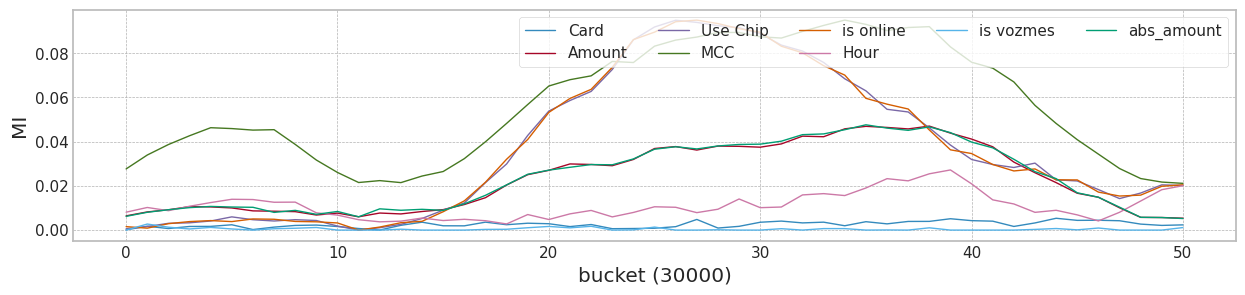

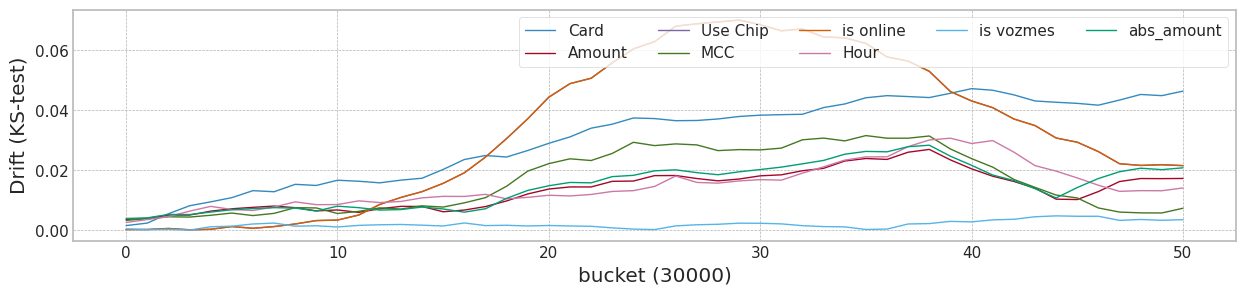

In [ ]:

train_size = 30000
test_size = 3000

X1,Y1 = check_mi_drift(X, y.values,train_size, test_size)

MI Analysis MI Max 0.02838, Min 0.00038, Mean 0.00683, Std 0.00866
cuda:0


100%|██████████| 1000/1000 [06:21<00:00,  2.62it/s]

MSE: 0.10
RMSE: 0.32


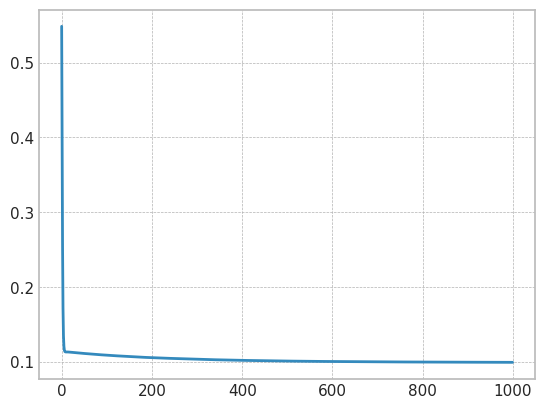

F1 Score:0.00000
Dataset structure X_train, torch.Size([30000, 8]) X_test, torch.Size([30000, 8]) X_live (182358, 8)
Truncate 156222 rows from live_set (182358, 8)


100%|██████████| 51/51 [00:00<00:00, 96.38it/s]


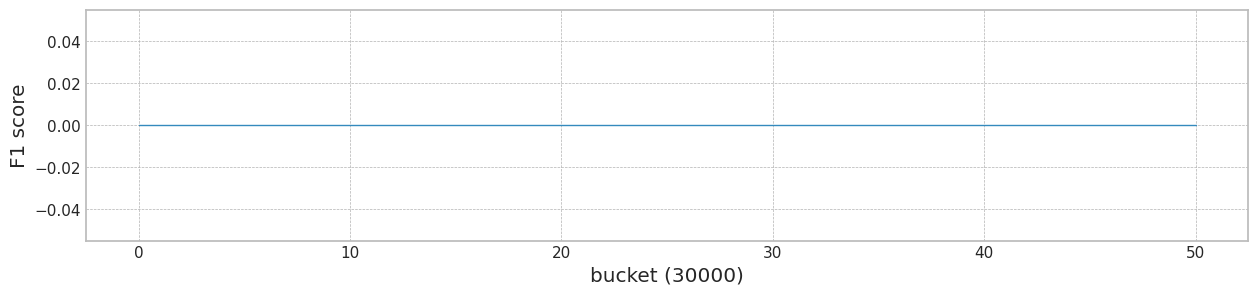

   test_f1  init_f1  mean_f1  last_f1   SUM(MI)
0      0.0      0.0      0.0      0.0  0.054619


In [ ]:
model,df = train_classificaion_model(X1,Y1,train_size, test_size)